# Sacramento Kings — International Targets
**Author:** Jay Chang  
**Date:** 10/10/2025 

# 1. Abstract

This project focuses on identifying high-value international basketball prospects who could strengthen the Sacramento Kings roster, with a particular emphasis on two-way player impact. Leveraging mock performance data from major European leagues (EuroLeague, EuroCup, ACB, and Serie A) and the NBA, I built an end-to-end data science pipeline—from data ingestion, cleaning, and feature engineering to exploratory analysis, modeling, and final ranking.

The analysis identifies top international prospects based on performance distributions, percentile rankings, and weighted impact metrics such as true shooting percentage, BPM, and defensive activity. This scoring system allowed for the creation of a ranked Top 25 Prospect List, highlighting players who stand out as versatile, NBA-ready contributors capable of addressing the Kings’ defensive weaknesses without compromising offensive value.

The final deliverable includes a clean, ranked scouting table with key metrics and distribution analyses that provide actionable insight for player targeting.

# 2. Data Loading & Inspection

## 2.1 Importing Libraries

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import hashlib
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
# import re

pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = (8, 5)

## 2.2 Loading Datasets

- *player.json* - player metadata
- *nba_box_player_season.json* - NBA box scores by season
- *international_box_player_season.json* - international league box scores by season

In [2]:
# Loading datasets (using 'path' method)
DATA = Path("../data")

players = pd.read_json(DATA / "player.json")
nba = pd.read_json(DATA / "nba_box_player_season.json")
intl = pd.read_json(DATA / "international_box_player_season.json")

## 2.3 Viewing Datasets

After loading the datasets, they can now be viewed and quickly scanned through to better understand the structure and its contents (column names, shapes, datatypes, etc.). This provides insight into exactly how to tackle the data processing steps, and is crucial in understanding what I'm working with. 

In [3]:
# Viewing dataset structures and contents
print("=== PLAYERS DATA ===")
print(players.info())
print(players.head())

print("\n=== NBA SEASON DATA ===")
print(nba.info())
print(nba.head())

print("\n=== INTERNATIONAL SEASON DATA ===")
print(intl.info())
print(intl.head())

=== PLAYERS DATA ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1663 entries, 0 to 1662
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   first_name  1663 non-null   object
 1   last_name   1663 non-null   object
 2   birth_date  1663 non-null   object
dtypes: object(3)
memory usage: 39.1+ KB
None
    first_name  last_name  birth_date
0         theo     greene  1995-12-26
1        miles   brussino  1993-02-01
2        ayres  bortolani  1969-01-20
3  kadoshnikov  christmas  1993-08-10
4      rashawn         de  1989-08-30

=== NBA SEASON DATA ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1685 entries, 0 to 1684
Data columns (total 55 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   first_name                       1685 non-null   object 
 1   last_name                        1685 non-null   object 
 2   season        

By viewing the dataset, I now have a better understanding of the data at hand and what it consists of. The Player dataset is the base dataset, consisting of player info (first/last name, birthdate). More importantly, I can now confirm that the NBA and International datasets consist of comprehensive box-score data from individual player seasons, and I now know the different metrics provided.

At first glance, the datasets seem relatively clean, but still need some processing to make them suitable for analysis. Additionally, there are some issues to address in the data processing step, specifically the presence of missing/null values (team, true_shooting_percentage, turnover_percentage, etc).

# 3. Data Cleaning & Processing

Now that the necessary libraries and datasets are loaded, I can begin the most exhaustive, yet essential, part of this report: standardizing, cleaning, and preparing the datasets for analysis. Viewing the structure of the data in the previous step gave me a better understanding of how to approach this, so several crucial data processing steps will be implemented. This includes standardizing/normalizing the data, assessing name coverage to identify unmatched cases, creating a stable key, handling missing values, detecting outliers, overall quality checks, and merging the datasets. Again, although the data *seems* pretty clean, these processes provide a harmless safeguard and can uncover hidden issues in our data. This upfront housekeeping reduces merge errors (many-to-many), preserves data integrity, and sets a solid foundation for the scouting insights that follow.

## 3.1 Standardizing & Normalization

In [4]:
# Standardizing column names (lowercasing and removing stray spaces)
for df in (players, nba, intl):
    df.columns = df.columns.str.strip().str.lower()

# Standardizing first/last names in ALL datasets (lowercasing, stripping)
for df in (players, nba, intl):
    df["first_name"] = df["first_name"].astype(str).str.strip().str.lower()
    df["last_name"] = df["last_name"].astype(str).str.strip().str.lower()

# Ensuring consistent birth_date format (propert datetime, YYYY-MM-DD string)
players["birth_date"] = pd.to_datetime(players["birth_date"], errors="coerce")
players["birth_date_str"] = players["birth_date"].dt.strftime("%Y-%m-%d").fillna("unknown_dob")


## 3.2 Name Matching & Unification

In [5]:
# Identifying unmatched names
nba_unmatched = nba[~nba.set_index(["first_name","last_name"]).index
                .isin(players.set_index(["first_name","last_name"]).index)]
intl_unmatched = intl[~intl.set_index(["first_name","last_name"]).index
                .isin(players.set_index(["first_name","last_name"]).index)]

print(f"\nNBA unmatched names: {nba_unmatched['first_name'].nunique()} players")
print(f"INTL unmatched names: {intl_unmatched['first_name'].nunique()} players")


NBA unmatched names: 50 players
INTL unmatched names: 0 players


Here, I have uncovered the first hiccup, giving us another important insight. The data indicates that 50 names in the NBA dataset don't correspond to any names listed in the Players dataset. So, further analysis will be done to find the root cause of this.

In [6]:
# Viewing the reason behind the unmatched names 
nba_unmatched_names = nba_unmatched[["first_name","last_name"]].drop_duplicates()                                                                                      

candidates = (nba_unmatched_names
              .merge(players[["first_name","last_name"]],
                     on=["first_name"],
                     how="inner",
                     suffixes=("_nba","_players")))
candidates.head(15)

,first_name,last_name_nba,last_name_players
0,youssou,mercer jr.,mercer
1,lopatin,wallace jr.,wallace
2,hasheem,della valle,della
3,rok,pittman jr.,pittman
4,aleksandar,love jr.,love
5,bostic,radoncic jr.,radoncic
6,vytenis,world peace,world
7,orlando,norvell jr.,norvell
8,datome,cissoko jr.,cissoko
9,brody,miller jr.,miller


Upon investigating this cause, it is found that the *players* match, but their *names* don't match due to suffixes and compound last names. Although dropping these 50 rows is a simple way to work around this, I will normalize the last names so they don't include the suffixes and compound names. The goal isn’t just tidier tables—it’s to ensure that the same player can be matched reliably across sources, so later steps (ID generation, merging, and analysis) are accurate, reproducible, and easy to reason about. Additionally, this allows for a holistic analysis of all given players in the datasets and prevents missing out on potential stars for our scouts to focus on, especially since some of the most intriguing and valuable international prospects may be ones who have prior NBA experience.

In [7]:
# NORMALIZING LAST NAMES

# Set of possible suffix options 
suffix_opts = {"jr", "jr.", "sr", "sr.", "ii", "iii", "iv", "v"}

# Function that strips the suffix from the last names
def strip_suffix(last_name: str) -> str:
    if not isinstance(last_name, str):
        return last_name 
    ln = last_name.strip().lower()
    # split by whitespace
    parts = ln.split()
    if len(parts) == 0:
        return ln
    # if last token is a known suffix, drop it
    if parts[-1] in suffix_opts:
        parts = parts[:-1]
    # rejoin
    return " ".join(parts).strip()

# Function normalizing the last name (stripping suffix, trimming compound names)
def normalize_last_name(name):
    if not isinstance(name, str):
        return name
    # remove suffixes (e.g., jr, III, etc.)
    base = strip_suffix(name)
    # take first token of compound names
    base = base.split()[0]
    return base

# Creating "base" last-name columns for ALL datasets
for df in (players, nba, intl):
    df["last_name_base"] = df["last_name"].apply(normalize_last_name)

# Checking if problem was solved (no more unmatched players)
nba_unmatched_base = nba[~nba.set_index(["first_name","last_name_base"]).index.isin(players.set_index(["first_name","last_name_base"]).index)]
print(f"\nNBA unmatched names: {nba_unmatched_base['first_name'].nunique()} players")


NBA unmatched names: 0 players


Here, it is clear that the problem was solved, and all the players listed in the NBA dataset can successfully be matched and merged to the Players dataset. 

## 3.3 Generating Player ID

Now, the next step is to generate player IDs, which involves creating a unique alphanumeric key for each player (player_id) based on their first name, last name, and birth date. This provides a reliable way to join the player info to the NBA and International season tables (which are assumed to come from different vendors), prevents name collisions (players with the same names), and allows for computing attributes like age-by-season later on.

*I would like to point out that I decided to create the IDs through hashing, creating a random, unique, and cleaner ID, rather than creating a more basic player_id (firstname_lastname_birthdate). This will allow merging to be smoother and neater later on.*

In [8]:
# Creating player_id (hash); alphanumeric ID with length of 12
def generate_id(row):
    key = f"{row['first_name']}_{row['last_name_base']}_{row['birth_date_str']}"  # using last_name_base as standardized version
    return hashlib.md5(key.encode()).hexdigest()[:12]

players["player_id"] = players.apply(generate_id, axis=1)

# Quick checks
print("Player_id values:")
print(players[["first_name", "last_name_base", "birth_date_str", "player_id"]].head())

# Verifying uniqueness (no duplicate players)
dup_count = players["player_id"].duplicated().sum()
print(f"\nDuplicate player_id count: {dup_count}")

Player_id values:
    first_name last_name_base birth_date_str     player_id
0         theo         greene     1995-12-26  d5e171b9e51c
1        miles       brussino     1993-02-01  c6c397960d95
2        ayres      bortolani     1969-01-20  e3c75a437e19
3  kadoshnikov      christmas     1993-08-10  a163820aad8f
4      rashawn             de     1989-08-30  8530411278e7

Duplicate player_id count: 0


## 3.4 Light Merge (Attaching Player ID)

Here I attach the stable player_id (and birth date) onto each stats table without building a single combined modeling table yet. This preserves referential integrity (every NBA/Intl row knows which players row it belongs to) while letting me continue cleaning per league. If anything gets filtered later (outliers, QC), I don’t lose the ability to trace rows back to the unique player.

In [9]:
# Building a de-duplicated key table from 'players'
    # If multiple 'players' rows share the same (first_name,last_name_base), keep the one with the most info
players_key = (
    players
    .assign(birth_date_rank=players["birth_date"].isna())  # False < True → non-null preferred
    .sort_values(["first_name", "last_name_base", "birth_date_rank", "birth_date"])
    .drop_duplicates(subset=["first_name", "last_name_base"], keep="first")
    [["first_name", "last_name_base", "player_id", "birth_date"]]
    .reset_index(drop=True)
)

print(f"players_key rows: {len(players_key)} (from players rows: {len(players)})")

players_key rows: 1663 (from players rows: 1663)


In [10]:
# NBA: many-to-one merge
nba_merged = nba.merge(
        players_key,
        on=["first_name", "last_name_base"],
        how="left",
        validate="m:1"   # many NBA rows to 1 players_key row
    )

# Diagnostics
nba_unmatched = nba_merged["player_id"].isna().sum()
print(f"NBA merged rows: {len(nba_merged):} | unmatched (no player_id): {nba_unmatched:}")

# INTERNATIONAL: many-to-one merge
intl_merged = intl.merge(
        players_key,
        on=["first_name", "last_name_base"],
        how="left",
        validate="m:1"
    )

# Diagnostics
intl_unmatched = intl_merged["player_id"].isna().sum()
print(f"International merged rows: {len(intl_merged):} | unmatched (no player_id): {intl_unmatched:}")

# Sanity check: No duplicate (player_id, season) pairs per league
def check_dup_player_season(df, name):
    cols = ["player_id", "season"]
    if all(c in df.columns for c in cols):
        dups = df.duplicated(subset=cols, keep=False).sum()
        print(f"{name}: duplicate (player_id, season) rows = {dups}")
        if dups > 0:
            display(df[df.duplicated(subset=cols, keep=False)]
                [["player_id","first_name","last_name", "season", "season_type", "league",
                  "games", "team", "points", "assists", "true_shooting_percentage"]].head(10))

check_dup_player_season(nba_merged,  "NBA")
check_dup_player_season(intl_merged, "International")

# 2) Overwrite the original dataset with merged one
nba  = nba_merged
intl = intl_merged

NBA merged rows: 1685 | unmatched (no player_id): 0
International merged rows: 3370 | unmatched (no player_id): 0
NBA: duplicate (player_id, season) rows = 0
International: duplicate (player_id, season) rows = 1306


,player_id,first_name,last_name,season,season_type,league,games,team,points,assists,true_shooting_percentage
0,d5e171b9e51c,theo,greene,2021,Full Season,EuroLeague,25,Redhawks,195,58,0.5886
1,d5e171b9e51c,theo,greene,2021,Full Season,Spain - ACB,17,Redhawks,135,37,0.6040
2,c6c397960d95,miles,brussino,2021,Full Season,EuroCup,12,Orange,82,9,0.6647
3,c6c397960d95,miles,brussino,2021,Full Season,Italy - Liga A,16,Orange,83,8,0.5027
4,a163820aad8f,kadoshnikov,christmas,2012,Full Season,EuroLeague,6,Redbirds,15,3,0.3029
5,a163820aad8f,kadoshnikov,christmas,2012,Full Season,Spain - ACB,18,Redbirds,86,8,0.5078
6,a163820aad8f,kadoshnikov,christmas,2013,Full Season,EuroLeague,15,Lions,77,5,0.6107
7,a163820aad8f,kadoshnikov,christmas,2013,Full Season,Spain - ACB,33,Lions,110,7,0.4969
8,a163820aad8f,kadoshnikov,christmas,2014,Full Season,EuroLeague,28,Lions,187,19,0.5828
9,a163820aad8f,kadoshnikov,christmas,2014,Full Season,Spain - ACB,42,Lions,290,36,0.6045


### 3.4.1 Merge Filtering

After the sanity check, it is apparent that there are duplicate rows in the merged dataset. These are same players with two rows *in the same season*. Although this would usually be seen as a data error, it is very common and expected in this context. Many players participate in both a domestic league and a pan-European league in the same season. To simplify the analysis while maintaining high-quality data, I prioritize stats from EuroLeague and EuroCup when duplicates occur for the same player and season. Domestic league stats are excluded in these duplicate cases, since EuroLeague and EuroCup provide stronger competition and are more predictive of NBA translatability.

This results in a clean, one-row-per-player-per-season dataset, focused on the highest competition levels.

In [11]:
# Identifying duplicates
dupes_mask = intl.duplicated(subset=["player_id", "season"], keep=False)
intl_dupes = intl[dupes_mask]
intl_nondupes = intl[~dupes_mask]

# Prioritizing EuroLeague/EuroCup
priority_leagues = ["EuroLeague", "EuroCup"]

# Sorting so EuroLeague and EuroCup appear first within each duplicate group
intl_dupes_sorted = (
    intl_dupes
    .assign(priority=intl_dupes["league"].apply(lambda x: 0 if x in priority_leagues else 1))
    .sort_values(["player_id", "season", "priority"])
)

# Dropping duplicates while keeping the priority leagues row per player-season
intl_dupes_filtered = intl_dupes_sorted.drop_duplicates(subset=["player_id", "season"], keep="first").drop(columns=["priority"])

# Recombining filtered duplicates with original non-duplicates
intl_filtered = pd.concat([intl_nondupes, intl_dupes_filtered], ignore_index=True)

# Sanity check
dups_remaining = intl_filtered.duplicated(subset=["player_id", "season"]).sum()
print(f"Duplicates remaining after filtering: {dups_remaining}")
print(f"Number of entries in filtered international dataset: {len(intl_filtered)}")


Duplicates remaining after filtering: 0
Number of entries in filtered international dataset: 2706


## 3.5 Initial Feature Engineering

Next, I will be creating new columns/features that are standard across all basketball metrics and statistics: Total Field Goals Made, Total Field Goals Attempted, Field Goal Percentage (FG%), Free Throw Percentage (FT%), and Total Rebounds. These are defining features for any basketball player, and are essential in evaluating the value of a player. The datasets provided don't have these features yet, so I will create them for better visibility and allowing for easier analyses and evaluation. Later on, I will add more comprehensive and standard features that are standard in NBA season box scores, such as the averages and per-game stats of FGM, FGA, and Rebounds.

In [12]:
def add_shooting_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    # Field goals
    df["total_FGM"] = (df["two_points_made"].fillna(0) + df["three_points_made"].fillna(0))
    df["total_FGA"] = (df["two_points_attempted"].fillna(0) + df["three_points_attempted"].fillna(0))
    df["FG%"] = (df["total_FGM"] / df["total_FGA"].replace(0, pd.NA))
   
    # Free throw percentage
    df["FT%"] = (df["free_throws_made"] / df["free_throws_attempted"].replace(0, pd.NA))
    
    # Three-point percentage
    df["3P%"] = (df["three_points_made"] / df["three_points_attempted"].replace(0, pd.NA))
    
    # Total Rebounds
    df["total_rebounds"] = (df["offensive_rebounds"].fillna(0) + df["defensive_rebounds"].fillna(0))

    # Formatting
    shooting_cols = ["FG%", "FT%", "3P%"]
    for col in shooting_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col])
   
    return df

nba = add_shooting_columns(nba)
intl_filtered = add_shooting_columns(intl_filtered)

# Quick check
print(nba[["total_FGM", "total_FGA", "FG%", "FT%", "3P%", "total_rebounds"]].head())
print(intl_filtered[["total_FGM", "total_FGA", "FG%", "FT%", "3P%", "total_rebounds"]].head())

   total_FGM  total_FGA       FG%       FT%       3P%  total_rebounds
0        142        364  0.390110  0.886792  0.375000              95
1        123        311  0.395498  0.854167  0.384615             129
2         56        157  0.356688  0.923077  0.322835              48
3         42         75  0.560000  0.815789  0.500000              77
4         66        141  0.468085  0.660377  0.266667             216
   total_FGM  total_FGA       FG%       FT%       3P%  total_rebounds
0         23         67  0.343284  0.750000  0.157895              20
1         20         61  0.327869  0.818182  0.380952              24
2        120        284  0.422535  0.895833  0.342342             112
3         51        134  0.380597  0.875000  0.363636              63
4         48        120  0.400000  0.800000  0.260870              94


## 3.6 Diagnosing and Handling Missing Values

In this step, I diagnose missing values in key rate and efficiency statistics to understand whether they are expected or unexpected. Many NaNs in basketball data are not “missing” in the traditional sense, but rather mathematically undefined, often caused by players recording 0 field goal attempts or possessions. For example:

- If FGA = 0, then free_throw_rate (FTA/FGA) is undefined.
- If a player has no possessions, turnover percentage may be undefined.

So instead of imputing values blindly, I first check whether each NaN corresponds to a logical basketball reason (e.g., FGA = 0). This helps me preserve the integrity of the data, identify real errors vs. expected undefined values, and document how much of the missingness is explainable. 

In [13]:
# DIAGNOSTICS

def missing_summary(df: pd.DataFrame, name: str):
    counts = df.isna().sum()
    pct = (df.isna().mean() * 100).round(1)
    out = (
        pd.DataFrame({"missing_rows": counts, "missing_pct": pct})
        .query("missing_rows > 0")
        .sort_values("missing_rows", ascending=False)
    )
    print(f"\n{name}: {len(out)} columns have missing values.")
    display(out)
    return out
    
nba_missing_pre  = missing_summary(nba,  "NBA (pre-handling)")
intl_missing_pre = missing_summary(intl_filtered, "International (pre-handling)")


NBA (pre-handling): 11 columns have missing values.


,missing_rows,missing_pct
team,246,14.6
3P%,229,13.6
FT%,107,6.4
FG%,11,0.7
free_throw_rate,11,0.7
true_shooting_percentage,11,0.7
three_point_attempt_rate,11,0.7
turnover_percentage,9,0.5
calculated_possessions,3,0.2
plays_used,3,0.2



International (pre-handling): 9 columns have missing values.


,missing_rows,missing_pct
3P%,396,14.6
FT%,206,7.6
internal_box_plus_minus,53,2.0
free_throw_rate,46,1.7
three_point_attempt_rate,46,1.7
FG%,46,1.7
true_shooting_percentage,40,1.5
turnover_percentage,32,1.2
team,16,0.6


By creating these summary tables, it provides a clear picture of which variables are affected and how much. This prevents blind imputation and makes my decisions rooted in basketball logic. This is important because, as an example, filling missing "true_shooting_percentage" values with 0 would incorrectly imply terrible efficiency, when in reality, these players may have had no shot/free-throw attempts or relevant playing time. 

These stats, such as internal_box_plus_minus, which is calculated on a per 100 possessions basis, should be left as missing (NaN) since this is likely due to these players not having at least 100 possessions in a given season, and because imputing them with a 0 would mean they had an average box-plus-minus score. Similarly, true shooting percentage mathematically can't be calculated without FGA or FTA, turnover percentage can't be calculated without FGA, FTA, or turnovers, and free-throw/three-point attempt rates can't be calculated without field goal attempts. With this in mind, I will check to see if this is the case or not. 

Notably, we can also ignore the missing rows for the FG%, FT%, and 3P% columns, since those would be expected (players that never took a shot or free throw).

In [14]:
# Key rate/efficiency columns to check
rate_cols = [
    "true_shooting_percentage",
    "free_throw_rate",
    "three_point_attempt_rate",
    "turnover_percentage",
    "internal_box_plus_minus"
]

def diagnose_missing_values(df: pd.DataFrame, name: str):
    print(f"\nDiagnosing missing values in {name}...")
    for col in rate_cols:
        if col not in df.columns:
            continue
            
        total_missing = df[col].isna().sum()
        # Missing values where FGA == 0 → expected (e.g. TS%, FTr, 3PAr)
        expected_missing = df[(df["total_FGA"] == 0) & (df[col].isna())].shape[0]
        # Missing values where FGA > 0 → unexpected
        unexpected_missing = df[(df["total_FGA"] > 0) & (df[col].isna())].shape[0]

        # Display a preview of unexpected cases if they exist
        if unexpected_missing > 0:
            print(f"{col}: {unexpected_missing} unexpected NaNs found.")
            display(
                df.loc[
                    (df["total_FGA"] > 0) & (df[col].isna()),
                    ["first_name", "last_name", "season", "total_FGA", "possessions", col]
                ].head(10)
            )
        else:
            print(f"{col}: all NaNs are expected (FGA = 0).")

nba_missing_diag = diagnose_missing_values(nba, "NBA")
intl_missing_diag = diagnose_missing_values(intl_filtered, "International")


Diagnosing missing values in NBA...
true_shooting_percentage: all NaNs are expected (FGA = 0).
free_throw_rate: all NaNs are expected (FGA = 0).
three_point_attempt_rate: all NaNs are expected (FGA = 0).
turnover_percentage: all NaNs are expected (FGA = 0).
internal_box_plus_minus: 1 unexpected NaNs found.


,first_name,last_name,season,total_FGA,possessions,internal_box_plus_minus
54,elton,bagaric,2013,13,65.7645,NaN



Diagnosing missing values in International...
true_shooting_percentage: all NaNs are expected (FGA = 0).
free_throw_rate: all NaNs are expected (FGA = 0).
three_point_attempt_rate: all NaNs are expected (FGA = 0).
turnover_percentage: all NaNs are expected (FGA = 0).
internal_box_plus_minus: 7 unexpected NaNs found.


,first_name,last_name,season,total_FGA,possessions,internal_box_plus_minus
93,marcelo,mccalebb,2020,124,774.0804,NaN
874,liraz,sexton,2020,194,988.8445,NaN
1134,niccolo,fortas,2020,217,1070.4834,NaN
1168,morse,acie,2020,125,673.7194,NaN
1440,devonte,bretzel,2020,90,410.1511,NaN
1651,margiris,jacobs,2020,180,759.3157,NaN
2028,jaycee,kazemi,2020,14,79.9763,NaN


Fortunately, I can see that most of the missing values in our data are expected, and not the result of errors or inconsistencies. However, there are several cases of unexpected missing values for internal_box_plus_minus. Since this is calculated per 100 possessions, there are really only 6 unexpected cases (all in the International dataset). Since this stat won't affect my evaluation too much, I will choose to accept these missing values as they are. 

Now, the only missing values I have to actually handle are the "team" values. However, this will be a simple fix. I will simply replace the NaN with "Unknown". 

In [15]:
def handle_missing_values(df: pd.DataFrame, name: str) -> pd.DataFrame:
    df = df.copy()
    for c in ["team"]:
        if c in df.columns:
            was_missing = df[c].isna().sum()
            df[c] = df[c].fillna("Unknown")
           # df[f"{c}_was_missing"] = False
            # if was_missing > 0:
                # df.loc[df[c] == "Unknown", f"{c}_was_missing"] = True
            print(f"{name}: filled {was_missing} missing values in '{c}' with 'Unknown'.")
    return df

nba  = handle_missing_values(nba,  "NBA")
intl_filtered = handle_missing_values(intl_filtered, "International")

NBA: filled 246 missing values in 'team' with 'Unknown'.
International: filled 16 missing values in 'team' with 'Unknown'.


Now, all missing values were diagnosed and handled appropriately. 

## 3.7 Standardizing Units

In this step, I standardize the units of all rate and percentage columns across both NBA and International datasets. Since these columns were originally expressed inconsistently — some as proportions (0–1), others as percentages (0–100), and some with irregular values — I converted all proportion values (0–1) into percentages (0–100) to make them consistent and more interpretable. 

This simplifies exploratory analysis and reporting, ensuring that every statistic is expressed in the same, intuitive format, and ensures that downstream analysis (e.g., outlier detection, modeling) interprets these columns correctly and consistently. This is particularly important when merging datasets from multiple sources, as inconsistent units can lead to misleading insights or unstable model behavior.

In [16]:
# Only these three columns are listed in proportions
pct_cols = [
    "true_shooting_percentage",
    "free_throw_rate",
    "three_point_attempt_rate",
    "FG%",
    "FT%",
    "3P%"
]

def convert_to_percent(df, cols):
    df = df.copy()
    for c in cols:
        if c in df.columns:
            # Convert to percentage only for rows clearly stored as proportion
            df.loc[df[c] <= 1, c] = df.loc[df[c] <= 1, c] * 100
    return df

nba = convert_to_percent(nba, pct_cols)
intl_filtered = convert_to_percent(intl_filtered, pct_cols)

# Formatting
nba[pct_cols] = nba[pct_cols].round(1)
intl_filtered[pct_cols] = intl_filtered[pct_cols].round(1)

## 3.8 Detecting and Handling Outliers

### 3.8.1 Eliminating Low Sample Players

In this step, I flag players with insufficient playing time or sample size to ensure they don’t distort distributions, advanced statistics, or downstream modeling. 

Many outlier values (or NaN values) in rate stats (e.g., rebounding %, true shooting %) come from players who logged very few minutes, games, or possessions. These small samples can exaggerate or produce unstable metrics. More importantly, it is very difficult to evaluate players who have barely played.

By setting reasonable thresholds based on minimum games, minutes, and possessions, I am able to flag these outlier samples. This ensures that the primary recommendations are based on meaningful playing time, while the NBA dataset serves as a realistic benchmark for interpreting performance metrics. Players below the threshold are flagged and placed in a separate “low-sample” group for potential secondary insights, such as monitoring younger or late-season players with small but interesting samples.

In [17]:
def flag_low_sample_players(df, name, min_games, min_minutes, min_possessions):
    df = df.copy()

    # Creating boolean flag
    df["low_sample_flag"] = (
        (df["games"] < min_games) |
        (df["minutes"] < min_minutes) |
        (df["possessions"] < min_possessions)
    )
    # Quick summary of how many players are flagged
    total_flagged = df["low_sample_flag"].sum()
    print(f"{name}: {total_flagged} players flagged as low-sample"
          f"({(total_flagged / len(df) * 100):.1f}% of dataset)")

    return df

nba = flag_low_sample_players(nba, "NBA", min_games=6, min_minutes=60, min_possessions=70)
intl_filtered = flag_low_sample_players(intl_filtered, "International", min_games=4, min_minutes=60, min_possessions=85)

# Quick check
intl_filtered[intl_filtered["low_sample_flag"]].head()


NBA: 210 players flagged as low-sample(12.5% of dataset)
International: 408 players flagged as low-sample(15.1% of dataset)


,first_name,last_name,season,season_type,league,team,games,starts,minutes,points,two_points_made,two_points_attempted,three_points_made,three_points_attempted,free_throws_made,free_throws_attempted,blocked_shot_attempts,offensive_rebounds,defensive_rebounds,assists,screen_assists,turnovers,steals,deflections,loose_balls_recovered,blocked_shots,personal_fouls,personal_fouls_drawn,offensive_fouls,charges_drawn,technical_fouls,flagrant_fouls,ejections,points_off_turnovers,points_in_paint,second_chance_points,fast_break_points,possessions,estimated_possessions,team_possessions,usage_percentage,true_shooting_percentage,three_point_attempt_rate,free_throw_rate,offensive_rebounding_percentage,defensive_rebounding_percentage,total_rebounding_percentage,assist_percentage,steal_percentage,block_percentage,turnover_percentage,internal_box_plus_minus,last_name_base,player_id,birth_date,total_FGM,total_FGA,FG%,FT%,3P%,total_rebounds,low_sample_flag
8,aldemir,kalaitzakis,2019,Full Season,EuroCup,Falcons,2,2,39.70,20,5,11,3,6,1,2,0,1,6,1,0,2,1,0,0,6,8,6,0,0,0,0,0,0,0,0,0,69.4258,69.4258,1337.8054,24.2474,55.9,35.3,11.8,3.8597,20.7185,11.2390,7.9054,1.6587,15.0376,10.0604,4.6618,kalaitzakis,21a9317fcfe1,1988-06-16,8,17,47.1,50.0,50.0,7,True
16,zivanovic,pangos,2021,Full Season,EuroLeague,Buffaloes,1,0,0.47,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.8339,0.8339,1657.2596,0.0000,NaN,NaN,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,NaN,NaN,pangos,fde4a7185a43,2000-01-16,0,0,NaN,NaN,NaN,0,True
24,zaytsev,bhullar,2021,Full Season,Spain - ACB,Lancers,1,2,2.68,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4.8512,4.8512,1375.7208,0.0000,NaN,NaN,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,NaN,NaN,bhullar,fafd7f6a1702,2000-03-21,0,0,NaN,NaN,NaN,0,True
31,valiev,gordic,2021,Full Season,Spain - ACB,Roadrunners,1,0,7.18,0,0,0,0,0,0,2,0,0,2,1,0,0,2,0,0,0,1,1,0,0,0,0,0,0,0,0,0,13.4412,13.4412,1534.3080,5.7711,0.0,NaN,NaN,0.0000,33.5826,18.8148,18.5728,14.9082,0.0000,0.0000,NaN,gordic,7940d554ff60,2001-04-02,0,0,NaN,0.0,NaN,2,True
34,devaughn,schrempf,2021,Full Season,EuroLeague,Nittany Lions,7,2,49.57,4,2,5,0,3,0,0,1,3,1,1,0,1,2,0,0,0,6,2,0,0,0,0,0,0,0,0,0,86.9534,86.9534,1780.5074,9.0570,25.0,37.5,0.0,8.1202,4.3212,6.0954,5.8266,2.0329,0.0000,11.1111,-3.9818,schrempf,1a9e62a44b7c,1994-04-10,2,8,25.0,NaN,0.0,4,True


Here, I set thresholds for minimum number of games, minutes, and possessions that I think qualifies a player to be truly evaluated.

In [18]:
# Qualified players only (for modeling & ranking) - will keep same naming
intl_qualified = intl_filtered[~intl_filtered["low_sample_flag"]].copy()
nba_qualified = nba[~nba["low_sample_flag"]].copy()

# Excluded players 
intl_excluded = intl_filtered[intl_filtered["low_sample_flag"]].copy()
nba_excluded = nba[nba["low_sample_flag"]].copy()

print(f"International: {len(intl_qualified)} qualified, {len(intl_excluded)} excluded")
print(f"NBA: {len(nba_qualified)} qualified, {len(nba_excluded)} excluded")

International: 2298 qualified, 408 excluded
NBA: 1475 qualified, 210 excluded


### 3.8.2 Capping Unrealistic Values

Basketball data often contains statistical outliers — extreme values that are mathematically valid but not meaningful in the context of real-world performance. These usually occur in small samples (e.g., a player shooting 100% TS on 3 shots), data errors, or due to rare statistical noise.

To prevent these unrealistic values from distorting exploratory analysis and modeling, I apply domain-informed caps to selected percentage and rate statistics. These caps reflect upper bounds that are plausible in professional basketball, ensuring a more stable and interpretable dataset. Although the previous step effectively handled many outliers, this acts as a final safeguard. 

Importantly, outlier capping does not discard players — it simply prevents extreme values from dominating rankings and analyses.

In [19]:
cap_list = [
    "offensive_rebounding_percentage",
    "defensive_rebounding_percentage",
    "total_rebounding_percentage",
    "assist_percentage",
    "steal_percentage",
    "block_percentage",
    "turnover_percentage",
    "usage_percentage",
    "true_shooting_percentage",
    "three_point_attempt_rate",
    "free_throw_rate",
    "FG%",
    "FT%"
]

print("\nMax statistics (INTL):")
print(intl_qualified[list(cap_list)].max())

print("\nMax statistics (NBA):")
print(nba_qualified[list(cap_list)].max())


Max statistics (INTL):
offensive_rebounding_percentage     28.4883
defensive_rebounding_percentage     37.5758
total_rebounding_percentage         28.0269
assist_percentage                   54.7689
steal_percentage                     6.2497
block_percentage                    14.4107
turnover_percentage                 45.2017
usage_percentage                    46.3786
true_shooting_percentage            91.2000
three_point_attempt_rate            92.3000
free_throw_rate                    100.0000
FG%                                 81.6000
FT%                                100.0000
dtype: float64

Max statistics (NBA):
offensive_rebounding_percentage     28.6175
defensive_rebounding_percentage     38.7364
total_rebounding_percentage         29.5436
assist_percentage                   46.9331
steal_percentage                     4.8175
block_percentage                    14.5266
turnover_percentage                 36.1882
usage_percentage                    36.8325
true_shooting_

By viewing the max values first, this gives me an understanding of which statistics I need to enforce a cap on. Looking at this, I can see that the majority of statistics don't need a cap, even though some are higher than historically possible (e.g., Shaq's career ORB% ~25%, highest FT% ever in single season was 98.1%). In fact, I only see one stat that warrants a cap: three_point_attempt_rate. However, everything else seems within reason.

Again, these "higher-than-possible" values are most likely the result of small samples, but not enough to be unrealistic, since we addressed the sample issue in the previous step.

In [20]:
caps = {
    "three_point_attempt_rate": 95
}

def cap_values(df, caps_dict):
    df = df.copy()
    for col, cap in caps_dict.items():
        if col in df.columns:
            num_capped = (df[col] > cap).sum()
            df[col] = df[col].clip(upper=cap)
            if num_capped > 0:
                print(f"{col}: capped {num_capped} values at {cap}")
    return df

nba_qualified = cap_values(nba_qualified, caps)
intl_qualified = cap_values(intl_qualified, caps)

three_point_attempt_rate: capped 1 values at 95


## 3.9 Additional Feature Engineering (Per-Game Statistics)

In this step, I create a set of per-game features to standardize key performance metrics across players with varying amounts of playing time. This allows for fairer comparisons and more intuitive interpretation of player performance.

Per-game stats such as minutes per game (MPG), points per game (PPG), rebounds per game (RPG), assists per game (APG), and per-game shooting attempts/makes provide a normalized view of production that complements percentage and rate stats.

These features will be used in both exploratory analysis and the eventual shortlist of international players.

In [21]:
def per_game_features(df):
    df = df.copy()
    
    # Core per-game stats
    df["MPG"] = df["minutes"] / df["games"]
    df["PPG"] = df["points"] / df["games"]
    df["RPG"] = df["total_rebounds"] / df["games"]
    df["APG"] = df["assists"] / df["games"]

    # Shooting per-game
    df["avg_FGM"] = df["total_FGM"] / df["games"]
    df["avg_FGA"] = df["total_FGA"] / df["games"]
    df["avg_3PM"] = df["three_points_made"] / df["games"]
    df["avg_3PA"] = df["three_points_attempted"] / df["games"]
    df["avg_FTM"] = df["free_throws_made"] / df["games"]
    df["avg_FTA"] = df["free_throws_attempted"] / df["games"]

    # Defensive per-game
    df["SPG"] = df["steals"] / df["games"]
    df["BPG"] = df["blocked_shots"] / df["games"]
    df["TO"] = df["turnovers"] / df["games"]

    # Formatting
    per_game_cols = [
        "MPG", "PPG", "RPG", "APG",
        "avg_FGM", "avg_FGA", "avg_3PM", "avg_3PA",
        "avg_FTM", "avg_FTA", "SPG", "BPG", "TO"
    ]
    df[per_game_cols] = df[per_game_cols].round(1)

    return df

nba_qualified = per_game_features(nba_qualified)
intl_qualified = per_game_features(intl_qualified)

## 3.10 Final Quality Checks

Before moving into merging, exploratory analysis, and modeling, I performed a final set of quality checks to ensure the dataset is clean, logically consistent, and free of common data issues and unnecessary noise. 

These checks include verifying unique player-season identifiers, ensuring basketball logic is respected (e.g., no players with stats but zero games), confirming valid ranges for shooting and rebounding percentages, identifying any rows with inconsistencies or data entry errors, and dropping irrelevant columns.

This step helps guarantee that downstream analysis and player rankings are reliable, interpretable, and clean.

In [22]:
# Checking again for duplicates
def check_duplicates(df, name):
    dupes = df.duplicated(subset=["player_id", "season"], keep=False)
    n_dupes = dupes.sum()
    print(f"Number of dupes in {name}: {n_dupes}")
    
check_duplicates(nba_qualified, "NBA")
check_duplicates(intl_qualified, "International")

Number of dupes in NBA: 0
Number of dupes in International: 0


In [23]:
# Checking for free agents or inactive players (players with 0 games/minutes, or partial seasons)
nba_inactives = nba_qualified[(nba_qualified["games"] == 0) | (nba_qualified["minutes"] == 0) | (nba_qualified["season_type"] != "Full Season")]
print(f"\nNBA: {len(nba_inactives)} rows found with 0 games/minutes or partial seasons")

intl_inactives = intl_qualified[(intl_qualified["games"] == 0) | (intl_qualified["minutes"] == 0) | (intl_qualified["season_type"] != "Full Season")]
print(f"Intl: {len(intl_inactives)} rows found with 0 games/minutes or partial seasons")


NBA: 0 rows found with 0 games/minutes or partial seasons
Intl: 0 rows found with 0 games/minutes or partial seasons


In [24]:
# Logic checks
def logic_checks(df, name):
    print(f"\nLogic Checks for {name}")

    # FGM <= FGA
    bad_fga = df[df["total_FGM"] > df["total_FGA"]]
    print(f"FGM > FGA: {len(bad_fga)}")

    # 3PM <= 3PA
    bad_tpa = df[df["three_points_made"] > df["three_points_attempted"]]
    print(f"3PM > 3PA: {len(bad_tpa)}")

    # FTM <= FTA
    bad_fta = df[df["free_throws_made"] > df["free_throws_attempted"]]
    print(f"FTM > FTA: {len(bad_fta)}")

logic_checks(nba_qualified, "NBA")
logic_checks(intl_qualified, "International")


Logic Checks for NBA
FGM > FGA: 0
3PM > 3PA: 0
FTM > FTA: 0

Logic Checks for International
FGM > FGA: 0
3PM > 3PA: 0
FTM > FTA: 0


In [25]:
# Invalid range checks
def range_checks(df, name):
    print(f"\n--- Range Checks for {name} ---")

    # Checking if any percentage exceeds 100 or is negative
    percent_list = [col for col in df.columns if "percentage" in col or "rate" in col]
    for c in percent_list:
        if c in df.columns:
            invalid = ((df[c] < 0) | (df[c] > 100)).sum()
            if invalid > 0:
                print(f"{c}: {invalid} invalid values out of range.")

    # Check MPG upper bound
    mpg_invalid = (df["MPG"] > 60).sum()
    if mpg_invalid > 0:
        print(f"{mpg_invalid} players have MPG > 60.")

range_checks(nba_qualified, "NBA")
range_checks(intl_qualified, "International")


--- Range Checks for NBA ---

--- Range Checks for International ---


In [26]:
# Dropping irrelevant columns
cols_to_drop = ["season_type", "starts", "two_points_made", "two_points_attempted", "blocked_shot_attempts", 
                   "screen_assists", "deflections", "personal_fouls_drawn", "offensive_fouls", "technical_fouls", 
                   "flagrant_fouls", "ejections", "second_chance_points", "fast_break_points", 
                   "estimated_possessions", "team_possessions", "last_name_base", "low_sample_flag"]

nba_qualified = nba_qualified.drop(columns=[c for c in cols_to_drop if c in nba_qualified.columns])
intl_qualified = intl_qualified.drop(columns=[c for c in cols_to_drop if c in intl_qualified.columns])                   

All our checks passed, so now our data is fully cleaned! 

## 3.11 Final Merge

In this step, I prepare the final structured datasets that will be used for exploratory analysis, statistical modeling, and generating player rankings.

Rather than continuing to work with multiple raw or semi-processed tables, I consolidate and format the data to ensure consistent player IDs, feature sets, and units. Since the goal of this project is to evaluate and highlight international prospects relative to an NBA baseline, I prepare:

- A clean, merged master table for global comparisons and model training.
- Filtered qualified subsets (NBA and International separately) for more focused evaluation and analysis. 

In [27]:
# Align columns to ensure consistent schema
common_cols = list(set(nba_qualified.columns) & set(intl_qualified.columns))
master_table = pd.concat([nba_qualified[common_cols], intl_qualified[common_cols]], ignore_index=True)

print("Final analysis table shape:", master_table.shape)
master_table.head()

# Check for duplicates (shouldn't exist now)
dupes = master_table.duplicated(subset=["player_id", "season"]).sum()
print(f"Duplicate player-season pairs in master table: {dupes}")

# Confirm league counts
print(master_table["league"].value_counts())

Final analysis table shape: (3773, 57)
Duplicate player-season pairs in master table: 42
league
NBA               1475
EuroLeague         922
EuroCup            770
Italy - Liga A     320
Spain - ACB        286
Name: count, dtype: int64


Now, the final master-data table is merged. Here, we can see that there are 42 players who have played in both the NBA and one of the four international leagues. This can be a useful insight later on when evaluating players. I will flag these players so I can easily spot if they played in both leagues. 

In [28]:
# Create a boolean flag for duplicate player-season pairs
master_table["nba_intl"] = master_table.duplicated(
    subset=["player_id", "season"], keep=False
)

# Quick check
print("Number of flagged duplicate rows:", master_table["nba_intl"].sum())

Number of flagged duplicate rows: 84


In [29]:
# Creating "league_type" column that differentiates NBA vs. International leagues
master_table["league_type"] = master_table["league"].apply(
    lambda x: "NBA" if x == "NBA" else "International"
)

# 4. Exploratory Data Analysis (EDA)

In this phase of the project, I’ll conduct a structured Exploratory Data Analysis (EDA) to better understand the cleaned and engineered dataset. The EDA will focus on:

- Gaining a high-level understanding of the dataset’s structure, completeness, and league composition.
- Examining distributions and relationships of key basketball performance metrics like scoring, efficiency, and impact.
- Comparing NBA and international player profiles to set a meaningful context for identifying top international prospects.
- Highlighting potential outliers, patterns, or trends that may guide downstream modeling and player ranking.

Because one of the Sacramento Kings’ most pressing roster needs is improved defensive impact, this analysis and project as a whole places particular emphasis on identifying high-value two-way international players — those who can contribute efficiently on offense while making a meaningful impact on defense. These players are critical targets for elevating the team’s overall balance and competitiveness.

## 4.1 Dataset Overview

Before diving into specific metrics or visualizations, I start with a high-level overview of the dataset to confirm its structure and get a quick feel for its contents. This includes understanding the number of players, key variables, the league breakdown, and the overall completeness of the data. This step ensures that what I expect from the data matches its actual state, reducing surprises later in the analysis.

In [30]:
# Basic structure
print("Shape of analysis table:", master_table.shape)
print("\nColumn info:")
print(master_table.info())

# Quick look at first few rows
master_table.head(5)

# League breakdown
print("\nPlayer count by league:")
print(master_table["league"].value_counts())

# Missing values summary
missing_summary = master_table.isna().sum()
missing_summary = missing_summary[missing_summary > 0].sort_values(ascending=False)
print("\nColumns with missing values:")
print(missing_summary)

# Quick descriptive statistics
master_table.describe()

Shape of analysis table: (3773, 59)

Column info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3773 entries, 0 to 3772
Data columns (total 59 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   assist_percentage                3773 non-null   float64       
 1   charges_drawn                    3773 non-null   int64         
 2   TO                               3773 non-null   float64       
 3   avg_3PM                          3773 non-null   float64       
 4   steals                           3773 non-null   int64         
 5   FT%                              3741 non-null   float64       
 6   possessions                      3773 non-null   float64       
 7   FG%                              3773 non-null   float64       
 8   BPG                              3773 non-null   float64       
 9   birth_date                       3773 non-null   datetime64[ns]
 10  total_rebo

,assist_percentage,charges_drawn,TO,avg_3PM,steals,FT%,possessions,FG%,BPG,birth_date,total_rebounds,defensive_rebounding_percentage,loose_balls_recovered,APG,blocked_shots,block_percentage,avg_FTA,avg_FGA,true_shooting_percentage,points_off_turnovers,assists,free_throws_attempted,total_FGM,usage_percentage,personal_fouls,avg_FGM,three_point_attempt_rate,offensive_rebounding_percentage,total_FGA,RPG,total_rebounding_percentage,internal_box_plus_minus,turnover_percentage,season,minutes,steal_percentage,three_points_attempted,offensive_rebounds,PPG,points,free_throw_rate,points_in_paint,defensive_rebounds,three_points_made,games,turnovers,MPG,avg_3PA,free_throws_made,SPG,3P%,avg_FTM
count,3773.000000,3773.000000,3773.000000,3773.000000,3773.000000,3741.000000,3773.000000,3773.000000,3773.000000,3773,3773.000000,3773.000000,3773.000000,3773.000000,3773.000000,3773.000000,3773.000000,3773.000000,3773.000000,3773.000000,3773.000000,3773.000000,3773.000000,3773.000000,3773.000000,3773.000000,3773.000000,3773.000000,3773.000000,3773.000000,3773.000000,3767.000000,3773.000000,3773.000000,3773.000000,3773.000000,3773.000000,3773.000000,3773.000000,3773.000000,3773.000000,3773.00000,3773.000000,3773.000000,3773.000000,3773.000000,3773.000000,3773.000000,3773.000000,3773.000000,3373.000000,3773.000000
mean,13.970077,0.377684,1.273310,0.776438,19.959449,73.942609,1259.633234,45.569653,0.330957,1989-04-02 00:44:16.347733888,112.107342,15.483652,3.968460,1.687331,11.847071,1.729800,1.887702,6.505831,54.727935,0.050888,54.382719,57.547045,94.347999,19.757791,59.671349,2.968990,32.867665,6.012880,206.007421,3.347760,10.698197,-0.676181,14.980789,2016.631593,637.846567,1.804773,65.297376,29.443944,8.127511,255.091969,29.532998,0.00053,82.663398,23.240922,31.060164,37.993374,20.002703,2.196130,43.155049,0.649298,31.436614,1.413623
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,103.850700,8.300000,0.000000,1975-02-03 00:00:00,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.300000,23.000000,0.000000,0.000000,0.000000,2.000000,5.181800,1.000000,0.100000,0.000000,0.000000,5.000000,0.200000,0.409700,-15.578100,0.000000,2010.000000,60.020000,0.000000,0.000000,0.000000,0.200000,6.000000,0.000000,0.00000,0.000000,0.000000,4.000000,0.000000,2.600000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.054200,0.000000,0.700000,0.100000,6.000000,66.700000,427.781400,40.000000,0.100000,1986-03-31 00:00:00,32.000000,10.809100,0.000000,0.600000,1.000000,0.399100,0.900000,4.000000,50.300000,0.000000,12.000000,17.000000,31.000000,16.214300,24.000000,1.800000,14.000000,2.539400,69.000000,2.000000,6.760600,-2.964200,11.370100,2014.000000,231.800000,1.211800,10.000000,7.000000,4.800000,85.000000,18.400000,0.00000,24.000000,2.000000,14.000000,13.000000,14.500000,0.600000,12.000000,0.400000,26.700000,0.600000
50%,10.894900,0.000000,1.100000,0.600000,13.000000,75.800000,807.080300,44.600000,0.200000,1989-05-14 00:00:00,66.000000,14.598200,0.000000,1.200000,5.000000,1.152100,1.600000,6.100000,54.900000,0.000000,27.000000,37.000000,62.000000,19.450100,42.000000,2.800000,35.200000,4.715600,134.000000,2.900000,9.738900,-0.737100,14.334900,2017.000000,433.860000,1.706000,38.000000,15.000000,7.600000,170.000000,26.800000,0.00000,48.000000,13.000000,23.000000,26.000000,20.300000,2.000000,27.000000,0.600000,33.300000,1.100000
75%,18.816900,0.000000,1.700000,1.200000,26.000000,83.100000,1499.274500,50.500000,0.500000,1992-06-12 00:00:00,131.000000,19.630300,0.000000,2.200000,13.000000,2.443700,2.600000,8.600000,59.400000,0.000000,63.000000,70.000000,116.000000,23.192500,76.000000,4.000000,49.300000,8.861300,254.000000,4.300000,14.102800,1.501400,17.934900,2020.000000,776.350000,2.305100,87.000000,34.000000,11.000000,316.000000,37.400000,0.00000,96.000000,31.000000,42.000000,49.000000,25.400000,3.400000,54.000000,0.900000,38.700000,1.900000
max,54.768900,56.000000,4.800000,3.900000,191.000000,100.000000,7153.000000,85.700000,3.500000,2003-10-03 00:00

Quickly glancing over this, I can confirm insights that we addressed in the data processing/cleaning steps: the missing values of 3P%, FT%, and internal_box_plus_minus are expected, and the descriptive statistics shows us no glaring errors or outliers. However, I will analyze this further throughout this process. 

Before visualizing and analyzing several key metrics, I can view their descriptive statistics to gain a better understanding of them. 

In [31]:
key_metrics = ["PPG", "true_shooting_percentage", "internal_box_plus_minus",
           "BPG", "SPG", "RPG", "APG"]

nba_summary = nba_qualified[key_metrics].describe().T
intl_summary = intl_qualified[key_metrics].describe().T

print("NBA Summary Stats:")
display(nba_summary)

print("International Summary Stats:")
display(intl_summary)

NBA Summary Stats:


,count,mean,std,min,25%,50%,75%,max
PPG,1475.0,6.703593,4.312922,0.2000,3.5000,5.6000,9.0500,29.0000
true_shooting_percentage,1475.0,52.239119,6.811363,23.0000,48.6000,52.7000,56.6000,77.1000
internal_box_plus_minus,1475.0,-1.846956,2.817858,-13.4659,-3.4649,-1.8211,0.0403,8.3118
BPG,1475.0,0.357559,0.411358,0.0000,0.1000,0.2000,0.5000,3.5000
SPG,1475.0,0.528407,0.337522,0.0000,0.3000,0.5000,0.7000,2.4000
RPG,1475.0,3.224678,2.263419,0.2000,1.7000,2.6000,4.1000,14.2000
APG,1475.0,1.509966,1.453752,0.0000,0.6000,1.0000,1.9000,9.6000


International Summary Stats:


,count,mean,std,min,25%,50%,75%,max
PPG,2298.0,9.041471,4.029009,0.6000,6.00000,8.8000,11.700000,23.5000
true_shooting_percentage,2298.0,56.325413,7.970283,23.0000,51.60000,56.4000,61.100000,91.2000
internal_box_plus_minus,2292.0,0.077263,3.849785,-15.5781,-2.28275,0.2199,2.518025,12.7943
BPG,2298.0,0.313882,0.381076,0.0000,0.10000,0.2000,0.400000,2.6000
SPG,2298.0,0.726893,0.419807,0.0000,0.40000,0.7000,1.000000,2.7000
RPG,2298.0,3.426762,1.752379,0.2000,2.10000,3.1000,4.500000,12.5000
APG,2298.0,1.801175,1.535581,0.0000,0.70000,1.3000,2.400000,9.2000


I noticed we still have 6 missing values for internal_box_plus_minus, so before moving on to our model prep and modeling, I will remove these rows for simplicity. 

In [32]:
# Count missing before dropping
missing_before = intl_qualified["internal_box_plus_minus"].isna().sum()
print(f"Missing BPM before drop: {missing_before}")

# Drop rows where BPM is missing
intl_qualified = intl_qualified.dropna(subset=["internal_box_plus_minus"]).reset_index(drop=True)

# Count missing after dropping
missing_after = intl_qualified["internal_box_plus_minus"].isna().sum()
print(f"Missing BPM after drop: {missing_after}")
print(f"New shape of dataset: {intl_qualified.shape}")

Missing BPM before drop: 6
Missing BPM after drop: 0
New shape of dataset: (2292, 57)


## 4.2 Key Metric Distributions

In this step, I examine the distributions of core basketball performance metrics such as scoring, minutes, efficiency, defense, and impact. Visualizing these variables helps reveal how the data is spread, whether it’s skewed, and where outliers may exist.

Because this project focuses on identifying standout international players, understanding the distribution of these stats across NBA and international leagues provides essential context. By examining histograms and boxplots, I can quickly see how players cluster and where top performers separate themselves from the rest.

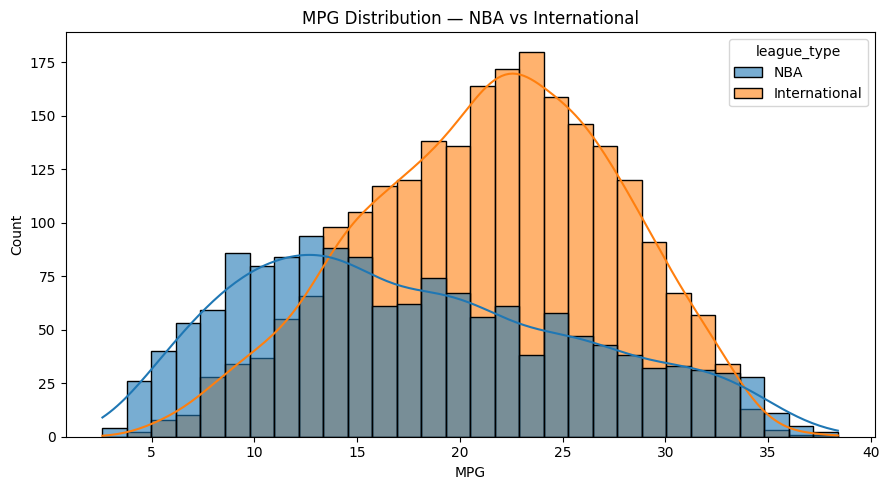

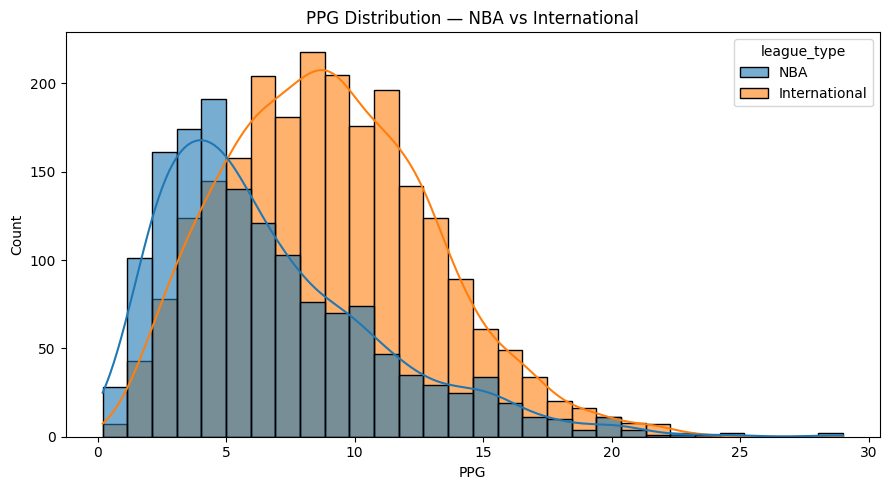

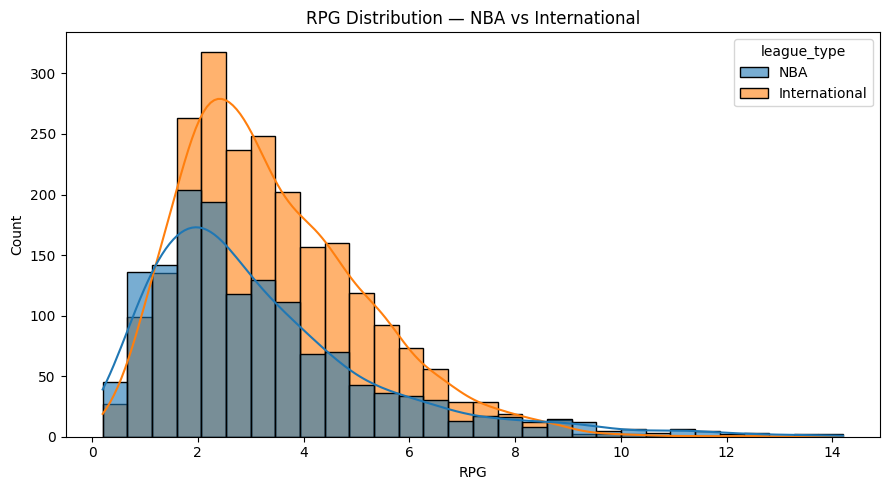

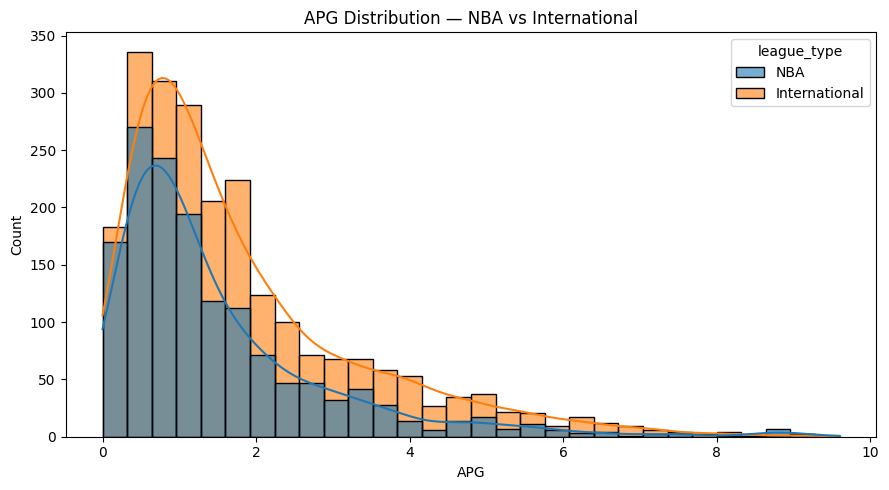

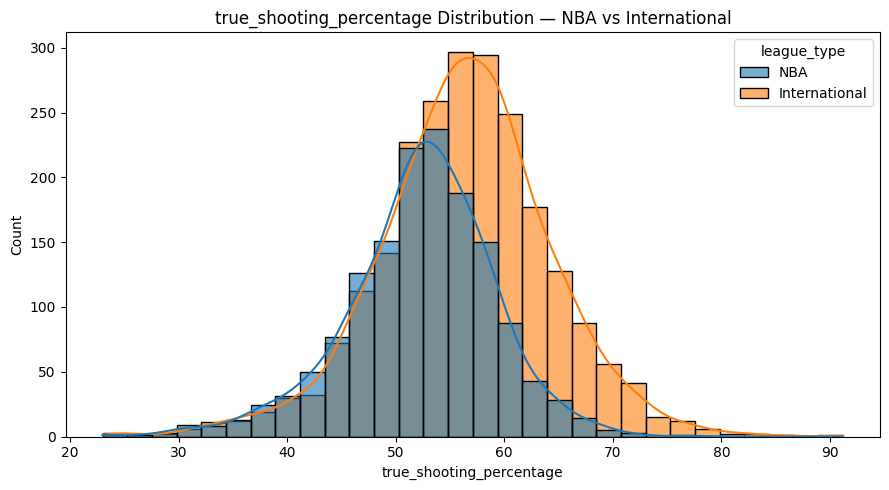

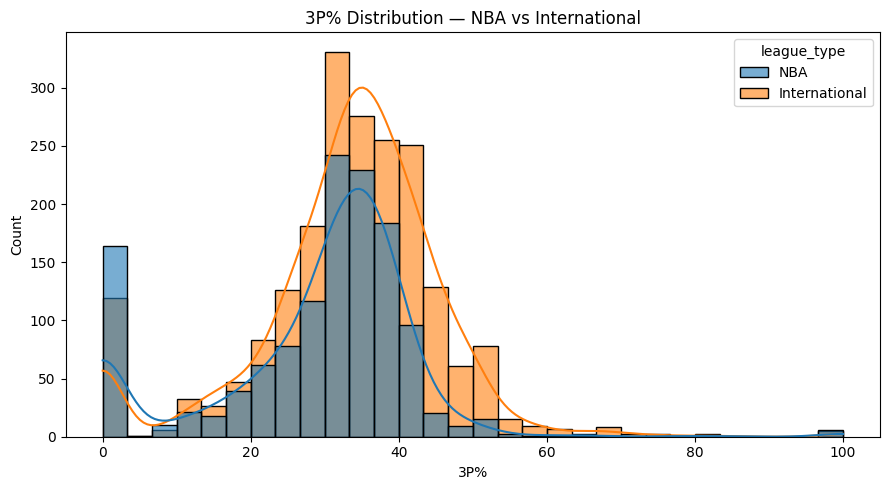

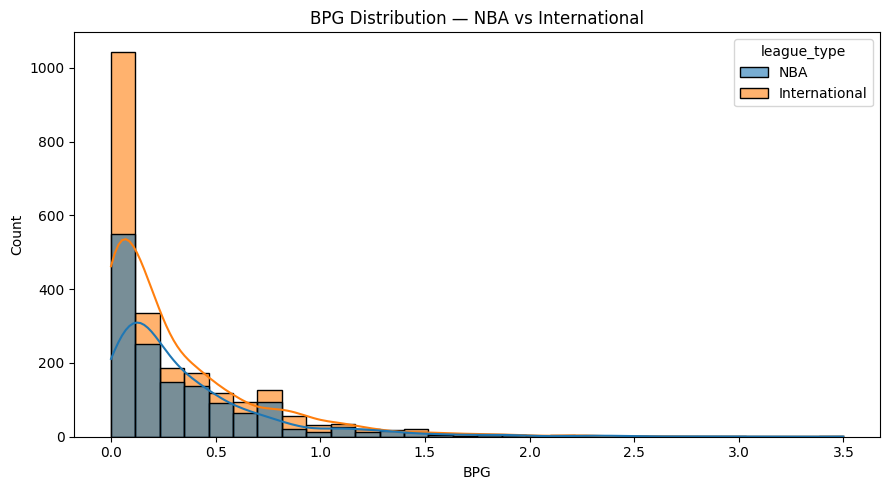

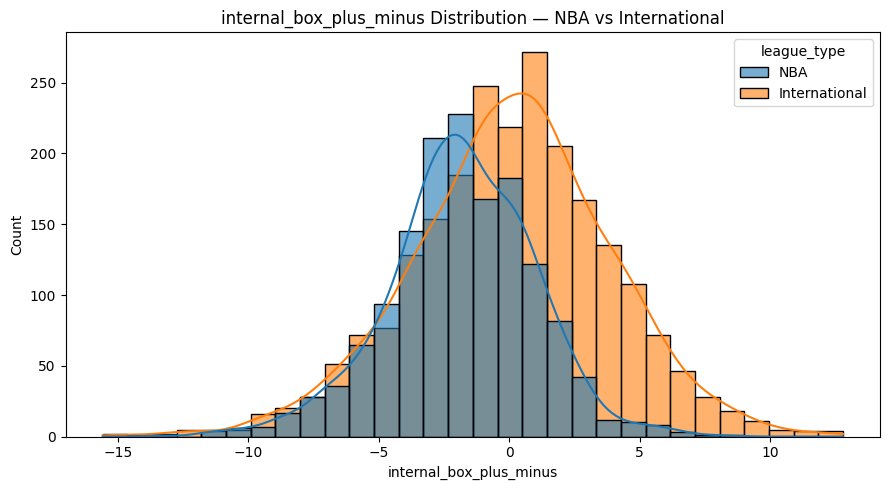

In [33]:
key_metrics = [
    "MPG",
    "PPG",
    "RPG",
    "APG",
    "true_shooting_percentage",
    "3P%",
    "BPG",
    "internal_box_plus_minus"
]

for col in key_metrics:
    plt.figure(figsize=(9,5))
    sns.histplot(
        data=master_table,
        x=col,
        hue="league_type",
        kde=True,
        bins=30,
        alpha=0.6
    )
    plt.title(f"{col} Distribution — NBA vs International")
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

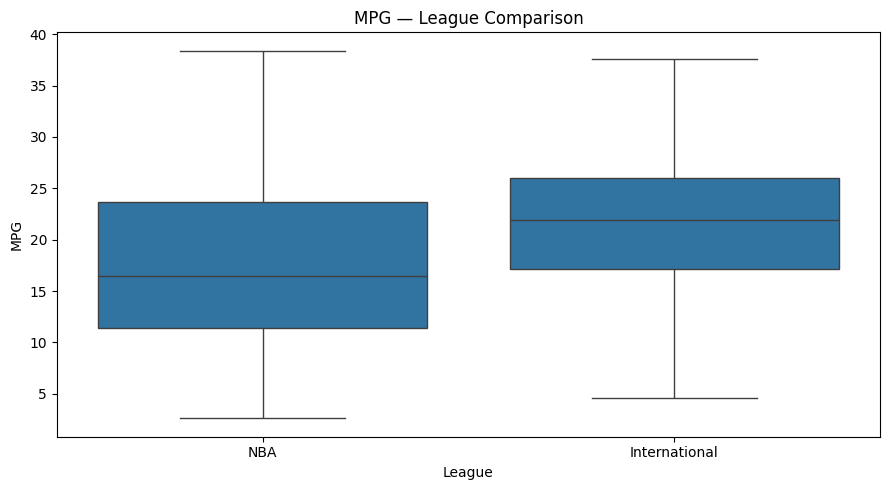

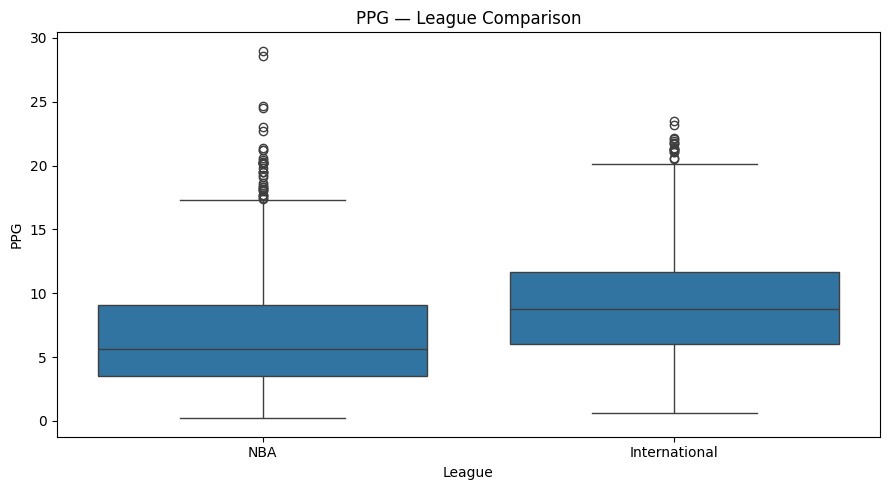

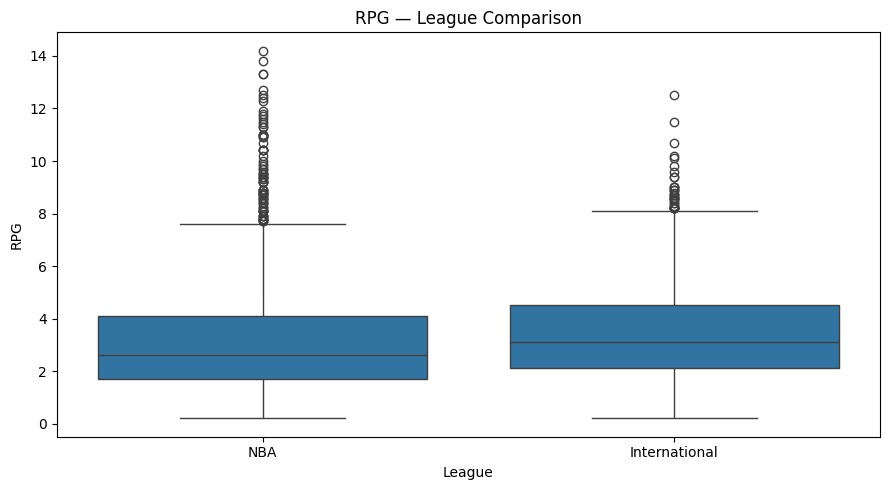

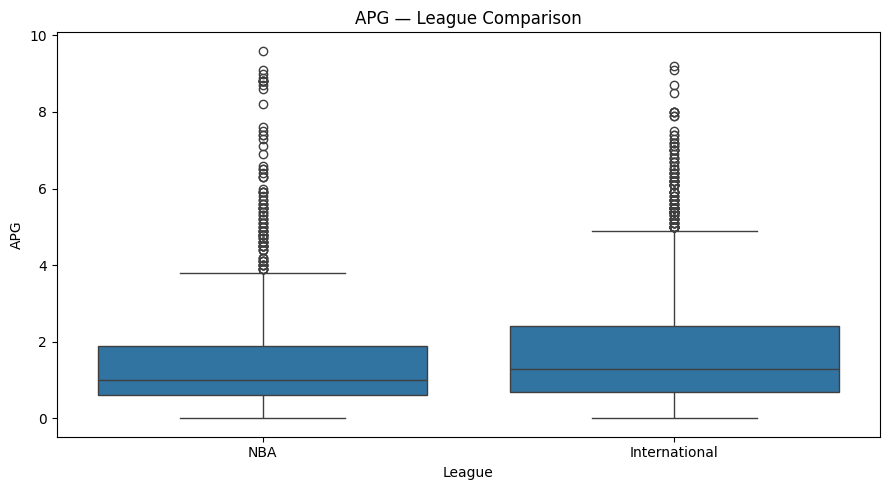

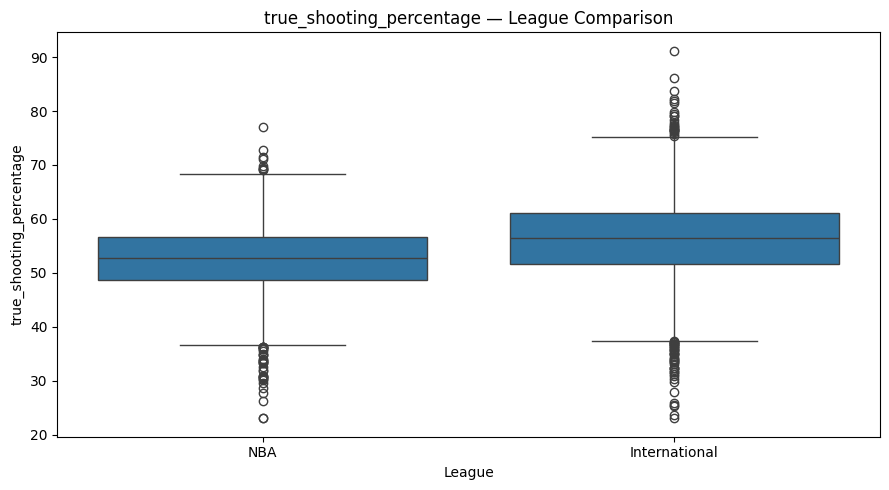

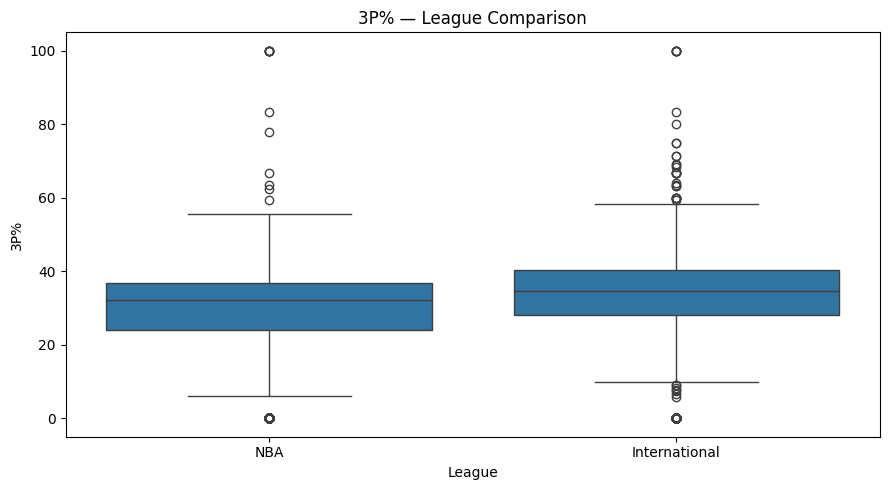

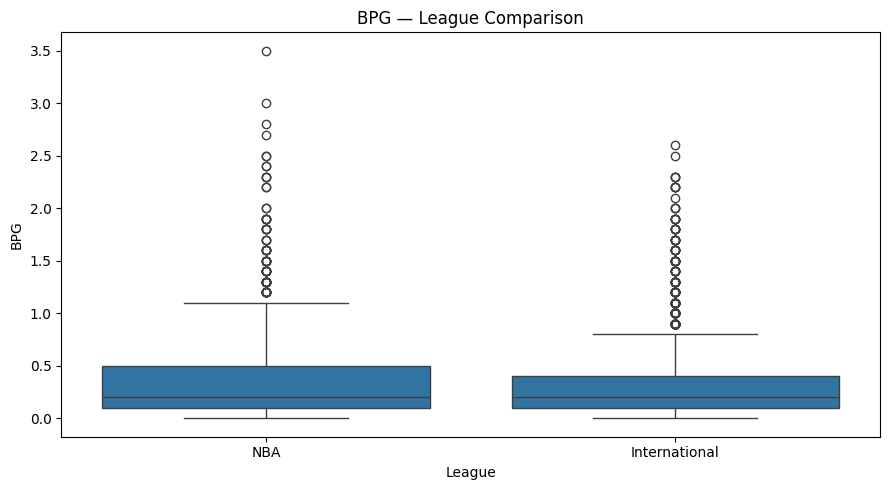

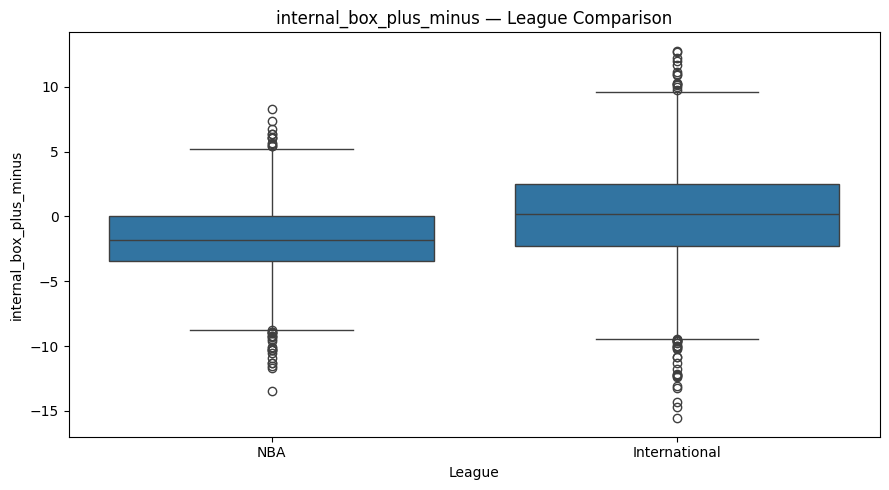

In [34]:
for col in key_metrics:
    plt.figure(figsize=(9,5))
    sns.boxplot(data=master_table, x="league_type", y=col)
    plt.title(f"{col} — League Comparison")
    plt.xlabel("League")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

**Minutes Per Game (MPG)**

- **Observation:** NBA has lower median but broader spread with more consistent minutes across the board; International is more centered with a high concentration from 20-30 MPG.
- **Interpretation:** Reflects differences in rotation patterns between leagues (NBA: deeper rotations, role players; International: smaller core, starters/primary contributors)
- **Scouting:** Higher MPG for international players --> greater on-court responsibility

**Points Per Game (PPG)**

- **Observation:** NBA has lower median, wider spread, long right tail with many high scorers; International has higher median, tighter clustering, capped upper end.
- **Interpretation:** International leagues show steadier, role-driven scoring, while the NBA has a longer tail of high-usage, outburst scorers.
- **Scouting:** Strong international scorers who pair efficiency with ≥20 MPG stand out because they’re outperforming a tighter scoring distribution.

**Rebounds Per Game (RPG)**

- **Observation:** NBA has similar median but broader spread with more extreme outliers; International has slightly higher center and more concentrated around 2-4 RPG.
- **Interpretation:** International rebounding shows a slightly higher central tendency and more consistency, while NBA rebounding is more uneven and dominated by a few high-end rebounders.
- **Scouting:** Top international rebounders stand out more clearly in a tighter distribution, making them easier to flag as potential high-impact targets for further evaluation.

**Assists Per Game (APG)**

- **Observation:** Both NBA and international distributions are right-skewed with most players averaging under 2 APG. International players show a slightly higher median and broader upper range, while NBA has a steeper drop-off and tighter spread.
- **Interpretation:** International playmaking is more evenly distributed across players, whereas NBA assists are concentrated among a smaller group of high-usage creators.
- **Scouting:** High-assist international players stand out more relative to their peers, signaling potential as primary or secondary facilitators in a more structured system.

**True Shooting Percentage**

- **Observation:** Both distributions are roughly normal, but international players show a slightly higher median and tighter concentration around the mid-50s to low-60s, while NBA has a wider spread and more lower-end outliers.
- **Interpretation:** International players tend to operate within more structured offensive systems, producing steadier shooting efficiency. NBA distributions reflect a mix of elite scorers and lower-efficiency, high-volume roles.
- **Scouting:** High-efficiency international scorers (≥60 TS%) stand out clearly, signaling players who can translate well as complementary scoring options.

Overall, these plots reveal several meaningful differences between NBA and international players that give us an initial insight into scouting strategies. International players tend to have higher medians across the board, with NBA players displaying wider variability and more extreme outliers (reflecting the league's higher concentration of top-end players). 

These patterns suggest a valuable scouting opportunity: international standouts, particularly efficient scorers with solid rebounding, passing, or defensive impact, are easier to identify because their performances stand out more clearly in narrower distributions. For a focus on two-way players, combining shooting efficiency (TS%, 3P%) with defensive presence (BPG, SPG) could highlight well-rounded international prospects who mirror the modern NBA’s demand for versatile contributors.

## 4.3 Relationship Exploration

In this step, I explore relationships between key performance metrics to understand how different aspects of a player’s game interact. For example, I want to examine whether high scorers are also efficient shooters, or whether rebounding and defensive impact (BPM) are closely related. Identifying these relationships helps me see which skills are most connected to overall performance and can guide how I weight or select features in later modeling. It also provides useful context for scouts when evaluating different player profiles.

### 4.3.1 Correlation Matrices

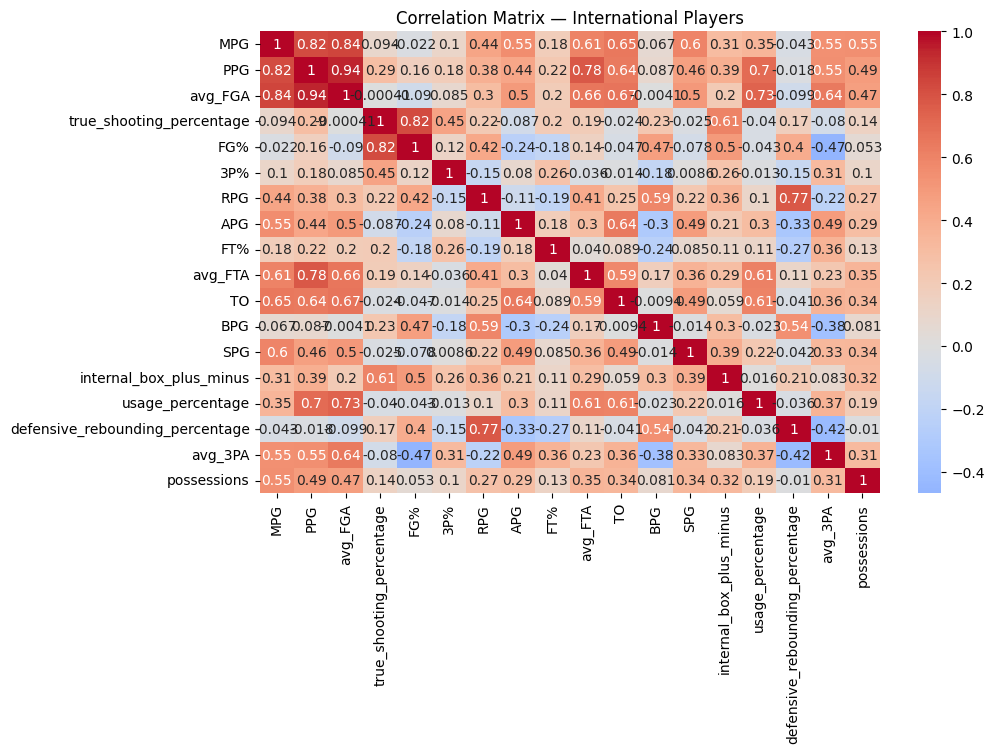

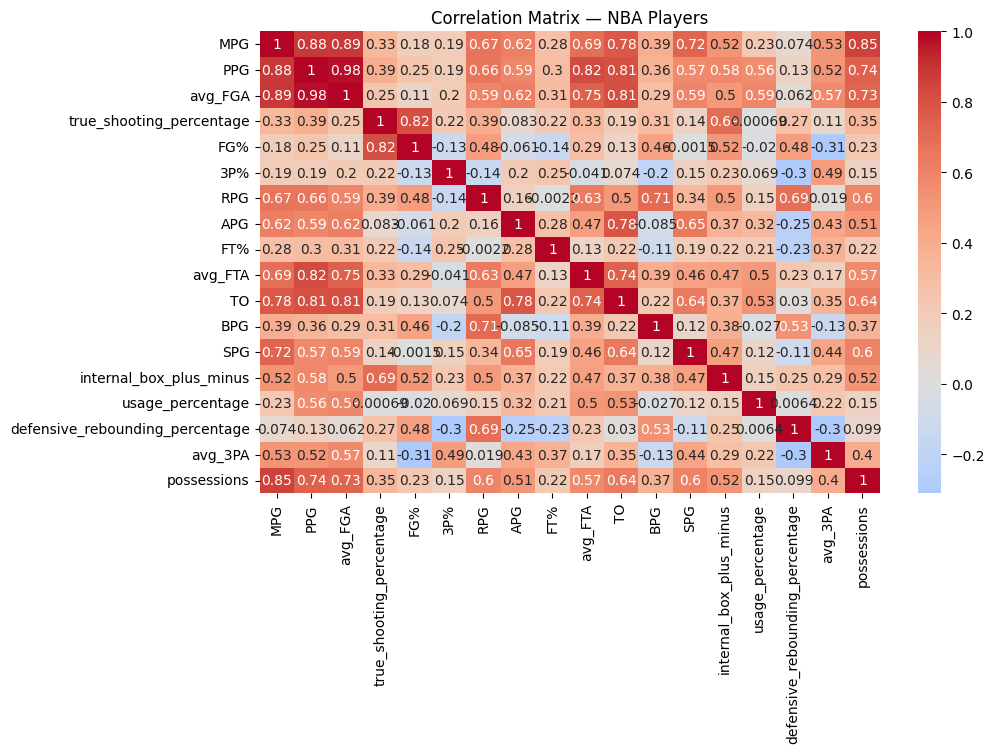

In [35]:
# Selecting key metrics for relationship exploration
corr_metrics = [
    "MPG", "PPG", "avg_FGA", "true_shooting_percentage",
    "FG%", "3P%", "RPG", "APG", "FT%", "avg_FTA", "TO", 
    "BPG", "SPG", "internal_box_plus_minus", "usage_percentage", 
    "defensive_rebounding_percentage", "avg_3PA", "possessions"
]

# Correlation matrix for International players only
corr_intl = intl_qualified[corr_metrics].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_intl, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Matrix — International Players")
plt.show()

# Optional: compare with NBA
corr_nba = nba_qualified[corr_metrics].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr_nba, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Matrix — NBA Players")
plt.show()

**Strong and Consistent Correlations Across Both Leagues**

- PPG, MPG, avg_FGA, avg_FTA, and possessions are all highly correlated (0.8-0.98).
    - This is intuitive: players who play more minutes take more shots, use more possessions, and score more points.
    - These are volume-driven stats, so their relationships are expected.
- PPG and shooting percentages (efficiency): moderate to low correlations.
    - High scorers are somewhat more efficient but not perfectly so. This suggests some players score a lot with average efficiency (volume scorers).
- Box-plus-minus and PPG/shooting percentages: moderate correlations (~0.5-0.6).
    - Scoring and shooting efficiency are both associated with overall impact, but not the only drivers of value.
- Playmaking (APG, RPG) and defensive stats (SPG, BPG, DR%) have a mild-to-moderate positive correlation with box-plus-minus, reflecting their importance in overall impact.

**Notable Differences Between NBA and International**

- Volume metrics are more tightly correlated in the NBA:
    - This suggests NBA rotations are more structured around consistent offensive roles, whereas international leagues may have more variability.
- Correlations with possessions are generally lower in international leagues:
    - Highlights the difference in pace and explosive playmaking.
- Usage percentage and scoring/scoring attempts (PPG, avg_FGA, avg_3PA) are considerably more correlated overseas.
    - Likely due to when someone has a high usage rate, they *are the offense*, compared to more balanced and deep offenses of the NBA (Tyrese Haliburton: high usage, moderate scoring).
- In the NBA, players who play more and score more also tend to contribute more across other box score categories (MPG, PPG, avg_FGA vs. RPG, APG, BPG, SPG).
    - This is likely due to more one-dimensional roles internationally compared to dynamic, two-way-demand players in the NBA.
 
**Scouting and Modeling Implications**

- Volume vs. Efficiency: High MPG/PPG players aren't always the most efficient.
    - Identify international players who score less but at higher efficiency.
- Impact vs. Shooting: Positive TS% and 3P% with box-plus-minus make these good starting points for finding effective offensive players.
- Usage: High usage in international play is a clearer indicator of scoring volume than in the NBA.
    - Low-usage, high-efficiency players overseas can stand out (efficient specialists, role players, off-ball scorers).
- The NBA standard is multi-category contributors:
    - The most valuable and NBA-ready international players we target are those who can contribute across multiple categories

### 4.3.2 Scatterplots

Similarly to the correlation matrices, scatterplots will allow me to visualize how key performance metrics relate to each other for NBA and International players. In particular, it can provide clear patterns, clusters, and standout performers that may signal high-value international prospects.

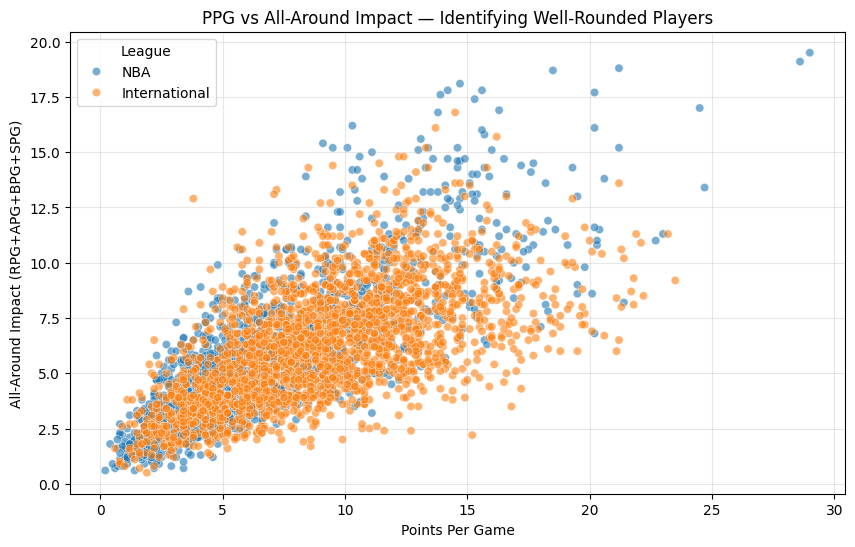

In [36]:
# Creating comprehensive "all-around" impact metric (APG+RPG+BPG+SPG)
master_table["all_around_impact"] = (
    master_table["RPG"] + master_table["APG"] + master_table["BPG"] + master_table["SPG"]
)

# Plot 1: All-Around Impact vs PPG 
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=master_table, x="PPG", y="all_around_impact",
    hue="league_type", alpha=0.6
)
plt.title("PPG vs All-Around Impact — Identifying Well-Rounded Players")
plt.xlabel("Points Per Game")
plt.ylabel("All-Around Impact (RPG+APG+BPG+SPG)")
plt.legend(title="League")
plt.grid(alpha=0.3)
plt.show()

This scatterplot shows a clear positive correlation between scoring and all-around impact. As scoring (PPG) increases, players generally contribute more across other box score areas (rebounds, assists, blocks, steals). NBA players are more spread at the top end, indicating a higher concentration of elite all-around contributors, while international players cluster more tightly in the mid-range.

**Insight:** International players in the upper-right quadrant (high PPG + strong all-around impact) represent the most NBA-ready two-way talents — scoring threats who also impact the game in multiple areas.

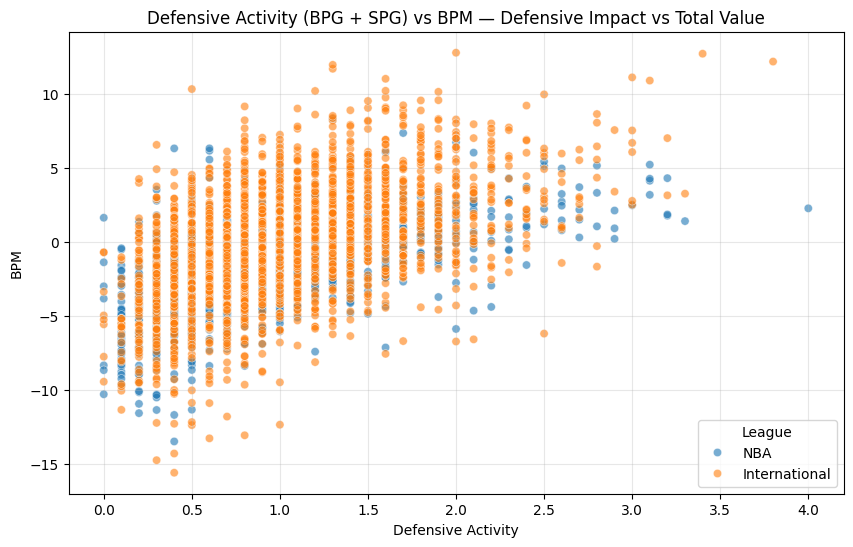

In [37]:
# Creating rough "defensive activity" metric (BPG + SPG)
master_table["defensive_activity"] = master_table["BPG"] + master_table["SPG"]

# Plot 2: Defensive Activity vs BPM
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=master_table, x="defensive_activity", y="internal_box_plus_minus",
    hue="league_type", alpha=0.6
)
plt.title("Defensive Activity (BPG + SPG) vs BPM — Defensive Impact vs Total Value")
plt.xlabel("Defensive Activity")
plt.ylabel("BPM")
plt.legend(title="League")
plt.grid(alpha=0.3)
plt.show()

This scatterplot shows a positive relationship between defensive activity and overall impact. Players who accumulate more steals and blocks per game generally have higher box-plus-minus values, indicating greater total on-court value. Both international and NBA players are clustered more tightly around lower-to-mid activity levels. However, several positive international outliers in the top end can signify elite defensive impact.

**Insight:** International players with both strong defensive activity and high box-plus-minus are promising two-way or defensive anchor profiles.

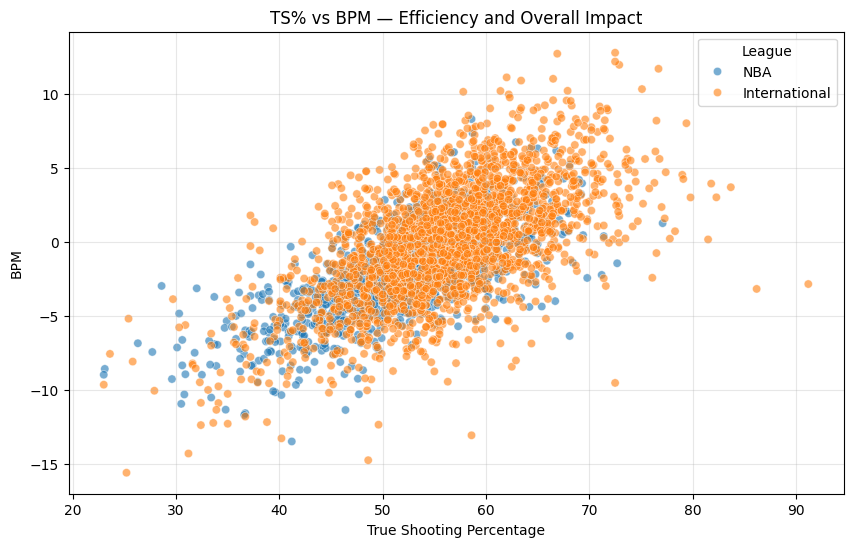

In [38]:
# Plot 3: TS% vs BPM
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=master_table, x="true_shooting_percentage", y="internal_box_plus_minus",
    hue="league_type", alpha=0.6
)
plt.title("TS% vs BPM — Efficiency and Overall Impact")
plt.xlabel("True Shooting Percentage")
plt.ylabel("BPM")
plt.legend(title="League")
plt.grid(alpha=0.3)
plt.show()

This plot shows a clear positive relationship between scoring efficiency (TS%) and overall impact (BPM). Players with higher shooting efficiency tend to contribute more positively to team performance. International players cluster more tightly in the mid-to-high TS% range, but with some dispersed points on both ends and some elite impact outliers at the top end. 

**Insight:** International players who combine high TS% and strong box-plus-minus stand out as efficient, high-impact scorers — key indicators of NBA translatability.

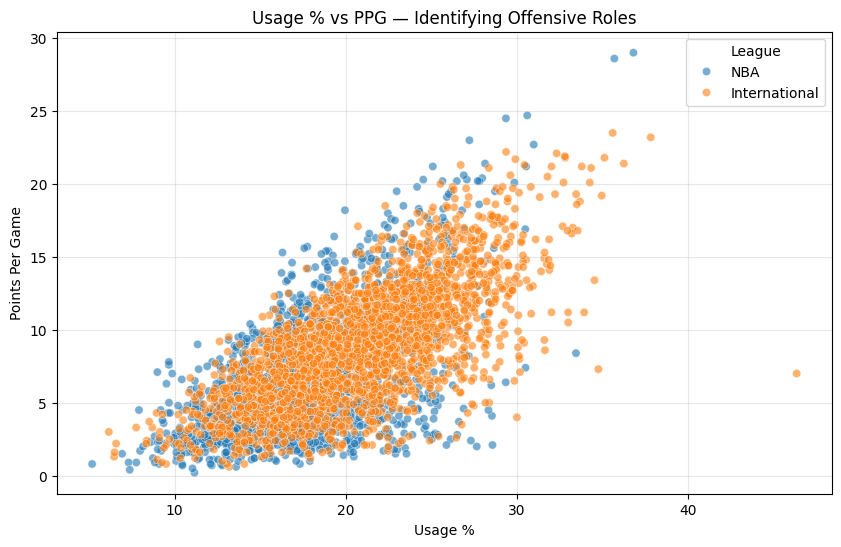

In [39]:
# Plot 4: Usage % vs. PPG
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=master_table, 
    x="usage_percentage", 
    y="PPG", 
    hue="league_type",  # "NBA" or "International"
    alpha=0.6
)
plt.title("Usage % vs PPG — Identifying Offensive Roles")
plt.xlabel("Usage %")
plt.ylabel("Points Per Game")
plt.legend(title="League")
plt.grid(True, alpha=0.3)
plt.show()

This plot shows a strong positive relationship between usage rate and scoring output for both NBA and international players. As players take on a higher share of their team’s offensive possessions, their points per game also tend to increase. NBA players appear slightly more dispersed at higher usage and scoring levels, reflecting a wider range of elite high-volume scorers. International players are more concentrated in the middle range, suggesting more balanced offensive roles across their leagues.

**Insight:** High-usage, high-PPG internationals may project as primary scorers, while low-usage, efficient scorers could be strong complementary fits in NBA systems.

# 5. Feature Engineering & Selection

## 5.1 Feature Engineering

In this step, I engineer additional basketball-relevant features that provide a more complete view of player performance. While the raw and per-game stats give a good starting point, these derived features help better capture offensive efficiency, defensive impact, and all-around contributions in a way that aligns with how modern NBA front offices evaluate talent.

In [40]:
# Calculating age at season from birthdate 
intl_qualified["age"] = (intl_qualified["season"] - intl_qualified["birth_date"].dt.year).astype("Int64")

# Offensive activity (scoring + assisting + made threes)
intl_qualified["offensive_activity"] = (
    intl_qualified["PPG"] + intl_qualified["APG"] + intl_qualified["avg_3PM"]
)

# Defensive activity metric (BPG + SPG + defensive rebounds)
intl_qualified["defensive_activity"] = (
    intl_qualified["BPG"] + intl_qualified["SPG"] + intl_qualified["defensive_rebounds"]
)

# Two-way impact stat (BPM + defense_activity + offense_activity)
intl_qualified["two_way_impact"] = (
    intl_qualified["internal_box_plus_minus"]
    + intl_qualified["defensive_activity"]
    + intl_qualified["offensive_activity"]
)

# Creating comprehensive "all-around" impact metric (APG + RPG + BPG + SPG)
intl_qualified["all_around_impact"] = (
    intl_qualified["RPG"] + intl_qualified["APG"] 
    + intl_qualified["BPG"] + intl_qualified["SPG"] 
)

# Sanity Check
print(intl_qualified[[
    "age", "MPG", "PPG", "APG", "BPG", "SPG", "RPG", 
    "offensive_activity", "defensive_activity",
    "two_way_impact", "all_around_impact", "internal_box_plus_minus"
]].head(5))

   age   MPG  PPG  APG  BPG  SPG  RPG  offensive_activity  defensive_activity  \
0   30  26.1  9.7  2.2  0.5  0.5  3.3                12.4                15.0   
1   31  22.6  6.3  0.7  0.1  0.3  2.7                 7.9                21.4   
2   34  24.1  8.7  2.4  0.1  0.8  3.0                12.1                93.9   
3   35  18.5  5.9  1.5  0.1  0.7  2.7                 8.3                49.8   
4   30  19.5  4.8  0.7  0.8  0.6  3.5                 6.2                70.4   

   two_way_impact  all_around_impact  internal_box_plus_minus  
0         23.2365                6.5                  -4.1635  
1         22.1162                3.8                  -7.1838  
2        105.4996                6.3                  -0.5004  
3         54.6614                5.0                  -3.4386  
4         77.0483                5.6                   0.4483  


**Age:** Player's age at the time of the season

**Offensive Activity:** PPG + APG + Average 3PM

- This feature encapsulates offensive capabilities, with key metrics worked alongside points. Specifically, APG and average 3PM, which are two essential parts of a team's offense in today's NBA.

**Defensive Activity:** BPG + SPG + Defensive Rebounds

- This feature encapsulates defensive capabilities, adding up essential metrics that signify a valued defensive player, including defensive rebounds to add more depth.

**Two-Way Impact:** Internal Box-Plus-Minus + Defensive Activity + Offensive Activity

- This feature measures a player's two-way impact by adding their offensive and defensive activity, along with internal BPM to account for overall impact on the court. The emphasis on players we want to scout are strong two-way players - those who are great on both offense and defense.

**All-Around Impact:** RPG + APG + BPG + SPG

- This feature differs from two-way impact, as it measures a player's impact and contribution on the court in stats besides points. We are looking for all-around players, not just players who can score. 

## 5.2 Feature Transformation & Scaling

In this step, I normalize and scale key features so they’re on comparable numerical ranges. This is especially important because raw basketball stats like PPG, BPM, and TS% can have different magnitudes and distributions.

By transforming these variables, I make it easier for models to detect meaningful patterns — and for downstream steps (like ranking) to treat all features equitably, not letting any single large-scale variable dominate.

In [41]:
# Key features to scale
features_to_scale = [
    "PPG", "true_shooting_percentage", "BPG",
    "SPG", "RPG", "APG", "offensive_activity",
    "defensive_activity", "two_way_impact",
    "all_around_impact", "internal_box_plus_minus"
]

# Scaling
scaler = MinMaxScaler()

# Fitting & transforming only on intl_qualified players
intl_scaled = intl_qualified.copy()
intl_scaled[features_to_scale] = scaler.fit_transform(
    intl_scaled[features_to_scale]
)

## 5.3 Feature Selection

In this step, I select a focused set of key performance metrics to include in the composite scoring model. The goal is not to maximize predictive accuracy but to ensure that:

- Selected features reflect on-court impact,
- Capture both offensive and defensive value,
- Align with the scouting priorities of Sacramento Kings (two-way impact, defense)

I prioritize features that are interpretable, actionable, and balanced across play styles.

In [42]:
# Selected key features for ranking
selected_features = [
    "PPG",
    "true_shooting_percentage",
    "offensive_activity",
    "BPG",
    "SPG",
    "defensive_activity",
    "RPG",
    "APG",
    "internal_box_plus_minus",
    "two_way_impact",
    "all_around_impact"
]

id_columns = ["player_id", "first_name", "last_name", "league", 
              "season", "minutes", "MPG", "games", "possessions", "age"]
intl_scaled = intl_scaled[id_columns + selected_features]

# Quick sanity check
intl_scaled.head()

,player_id,first_name,last_name,league,season,minutes,MPG,games,possessions,age,PPG,true_shooting_percentage,offensive_activity,BPG,SPG,defensive_activity,RPG,APG,internal_box_plus_minus,two_way_impact,all_around_impact
0,ad0f03849633,damian,roll,EuroCup,2012,156.36,26.1,6,272.2655,30,0.397380,0.250733,0.340491,0.192308,0.185185,0.059429,0.252033,0.239130,0.402314,0.106315,0.368098
1,ad0f03849633,damian,roll,EuroLeague,2013,203.16,22.6,9,358.9661,31,0.248908,0.297654,0.202454,0.038462,0.111111,0.084786,0.203252,0.076087,0.295861,0.102176,0.202454
2,ad0f03849633,damian,roll,Italy - Liga A,2016,893.00,24.1,37,1629.4526,34,0.353712,0.434018,0.331288,0.038462,0.296296,0.372029,0.227642,0.260870,0.531421,0.410245,0.355828
3,ad0f03849633,damian,roll,Italy - Liga A,2017,425.00,18.5,23,775.9696,35,0.231441,0.369501,0.214724,0.038462,0.259259,0.197306,0.203252,0.163043,0.427863,0.222418,0.276074
4,d8935694278f,kurucs,humphrey,EuroLeague,2020,525.67,19.5,27,954.3156,30,0.183406,0.403226,0.150307,0.307692,0.222222,0.278922,0.268293,0.076087,0.564859,0.305128,0.312883


# 6. Composite Scoring & Ranking

In this step, I’ll create a composite scoring model to rank international players based on their on-court impact. Rather than using complex predictive models, this approach builds a transparent weighted score from a curated set of features that reflect the Sacramento Kings' biggest needs:

- Two-way ability (offense + defense)
- Shooting efficiency and impact
- Playmaking & versatility

This method ensures easy and quick interpretation for scouts to know as to why a player ranks highly.

In [43]:
# Defining weights
weights = {
    "PPG": 0.075,
    "true_shooting_percentage": 0.18,
    "offensive_activity": 0.10,
    "BPG": 0.05,
    "SPG": 0.05,
    "defensive_activity": 0.10,
    "RPG": 0.05,
    "APG": 0.05,
    "two_way_impact": 0.195,
    "internal_box_plus_minus": 0.15
}

# Compute composite score
intl_scaled["composite_score"] = sum(
    intl_scaled[feat] * w for feat, w in weights.items()
)

# Rank players by score
intl_scaled = intl_scaled.sort_values(
    "composite_score", ascending=False
).reset_index(drop=True)

# Add rank column
intl_scaled["rank"] = intl_scaled.index + 1

In [44]:
merge_keys = ["player_id", "season"]

# Merging original qualified dataset with scaled dataset
intl_ranked = intl_qualified.merge(
    intl_scaled,
    on=merge_keys,
    how="left",
    suffixes=("", "_scaled")
)

Now that our prospects are fully ranked, I can visualize how they compare to the rest of the players in the datasets.

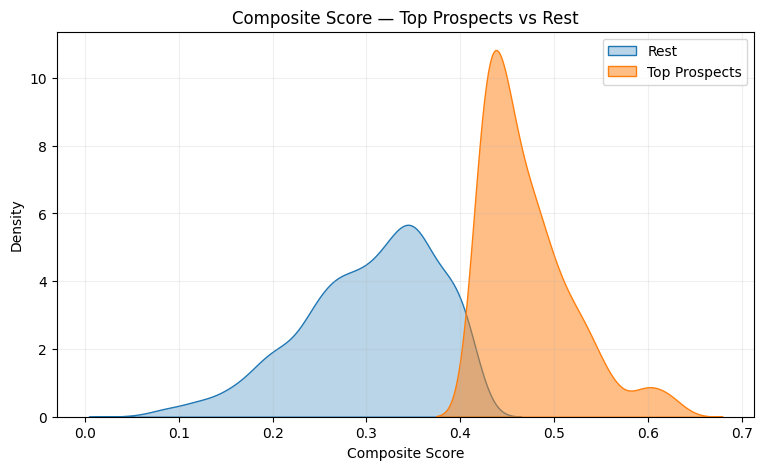

In [45]:
# Define top group (by rank or quantile)
cut = intl_ranked["composite_score"].quantile(0.80)  # top 20%
intl_ranked["is_top"] = intl_ranked["composite_score"] >= cut

plt.figure(figsize=(9,5))
sns.kdeplot(data=intl_ranked[~intl_ranked["is_top"]], x="composite_score", fill=True, alpha=0.3, label="Rest")
sns.kdeplot(data=intl_ranked[intl_ranked["is_top"]],  x="composite_score", fill=True, alpha=0.5, label="Top Prospects")
plt.title("Composite Score — Top Prospects vs Rest")
plt.xlabel("Composite Score")
plt.legend()
plt.grid(alpha=0.2)
plt.show()

# 7. Final Ranking

In this final step, I present the Top 25 international prospects based on a composite score that blends scoring efficiency, impact metrics, and defensive activity. The goal of this ranking is not simply to highlight the highest scorers, but to identify well-rounded, two-way players—those who can both generate efficient offense and contribute meaningfully on the defensive end.

Given that the Sacramento Kings’ biggest organizational gap lies on the defensive side of the floor, particular weight was placed on defensive impact metrics such as steals, blocks, and overall BPM, while still valuing efficient shooting and scoring versatility. This list represents players who profile as high-value, NBA-ready contributors capable of filling multiple roles on both ends of the court.

In [46]:
ranked_cols = [
    "rank", "tier", "composite_score", "first_name", "last_name", "age", 
    "league", "games", "MPG", "PPG", "avg_FGM", "avg_FGA", "FG%", "avg_3PM", 
    "avg_3PA", "3P%", "avg_FTM", "avg_FTA", "FT%", "true_shooting_percentage", 
    "RPG", "APG", "SPG", "BPG", "TO", "internal_box_plus_minus", "offensive_activity", 
    "defensive_activity", "two_way_impact", "all_around_impact"
]

top_25 = intl_ranked.sort_values(by="composite_score", ascending=False).head(25)

top_25["tier"] = pd.qcut(
    top_25["composite_score"], 
    q=[0, 0.55, 0.90, 1.0],
    labels=["Watchlist", "Strong Prospect", "Elite Prospect"]
)

top_25 = top_25[ranked_cols]
top_25

,rank,tier,composite_score,first_name,last_name,age,league,games,MPG,PPG,avg_FGM,avg_FGA,FG%,avg_3PM,avg_3PA,3P%,avg_FTM,avg_FTA,FT%,true_shooting_percentage,RPG,APG,SPG,BPG,TO,internal_box_plus_minus,offensive_activity,defensive_activity,two_way_impact,all_around_impact
329,1,Elite Prospect,0.637715,gortat,henderson,26,Italy - Liga A,48,33.2,16.4,5.3,11.4,46.7,1.8,4.6,39.4,3.9,4.2,92.6,61.7,5.6,1.7,1.4,0.8,2.4,6.1146,19.9,194.2,220.2146,9.5
349,2,Elite Prospect,0.633415,blazic,canaan,28,Italy - Liga A,21,32.2,21.2,6.8,16.6,40.8,2.2,6.1,36.4,5.5,6.4,85.2,54.7,9.0,1.9,1.6,1.1,3.8,1.6467,25.3,176.7,203.6467,13.6
933,3,Elite Prospect,0.624520,maynor,sweetney,25,Italy - Liga A,47,26.6,13.7,5.7,9.2,62.4,0.0,0.0,0.0,2.3,4.5,50.5,61.5,8.4,0.1,0.7,1.5,3.0,-1.0575,13.8,247.2,259.9425,10.7
984,4,Strong Prospect,0.623648,daniels,brimah,27,EuroLeague,24,27.3,16.6,6.2,10.0,62.3,0.0,0.0,NaN,4.2,5.3,78.1,67.4,10.7,1.0,0.4,0.9,1.4,6.2537,17.6,174.3,198.1537,13.0
997,5,Strong Prospect,0.621759,filipovity,tavares,27,Italy - Liga A,39,25.9,11.3,4.7,7.6,62.3,0.0,0.0,NaN,1.8,3.4,51.5,61.7,10.2,0.6,0.7,0.7,2.3,0.8255,11.9,252.4,265.1255,12.2
1609,6,Strong Prospect,0.619343,tanoulis,graham,28,Italy - Liga A,30,29.4,14.9,5.7,10.9,52.8,0.3,1.3,26.3,3.1,4.4,70.7,58.2,9.0,1.0,1.2,1.8,2.0,2.7865,16.2,198.0,216.9865,13.0
1592,7,Strong Prospect,0.618684,lonnie,dalembert,32,Italy - Liga A,28,29.6,15.8,5.1,10.7,47.5,1.9,5.2,36.7,3.7,4.5,82.5,62.4,7.4,3.4,0.9,0.2,3.2,4.2354,21.1,187.1,212.4354,11.9
838,8,Strong Prospect,0.617257,lampe,borg,31,EuroLeague,26,27.8,10.3,4.0,7.7,52.0,1.3,2.8,45.2,1.0,1.3,77.1,62.2,7.3,3.7,1.7,0.8,2.5,9.9801,15.3,166.5,191.7801,13.5
151,9,Strong Prospect,0.608917,aleksandar,love,27,EuroLeague,29,27.7,12.1,4.2,8.5,49.8,0.9,2.6,34.7,2.7,3.9,68.4,58.9,8.5,1.9,1.3,0.7,1.5,6.3844,14.9,195.0,216.2844,12.4
761,10,Strong Prospect,0.608488,jacobsen,gamble,32,Italy - Liga A,30,31.0,13.4,5.4,9.6,56.4,0.0,0.2,20.0,2.5,3.7,67.3,59.4,10.1,1.2,1.7,1.3,2.5,2.5283,14.6,192.0,209.1283,14.3
